In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_context('poster')

In [5]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
df = pd.read_pickle('CCPA.pkl.gz')

In [8]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [9]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

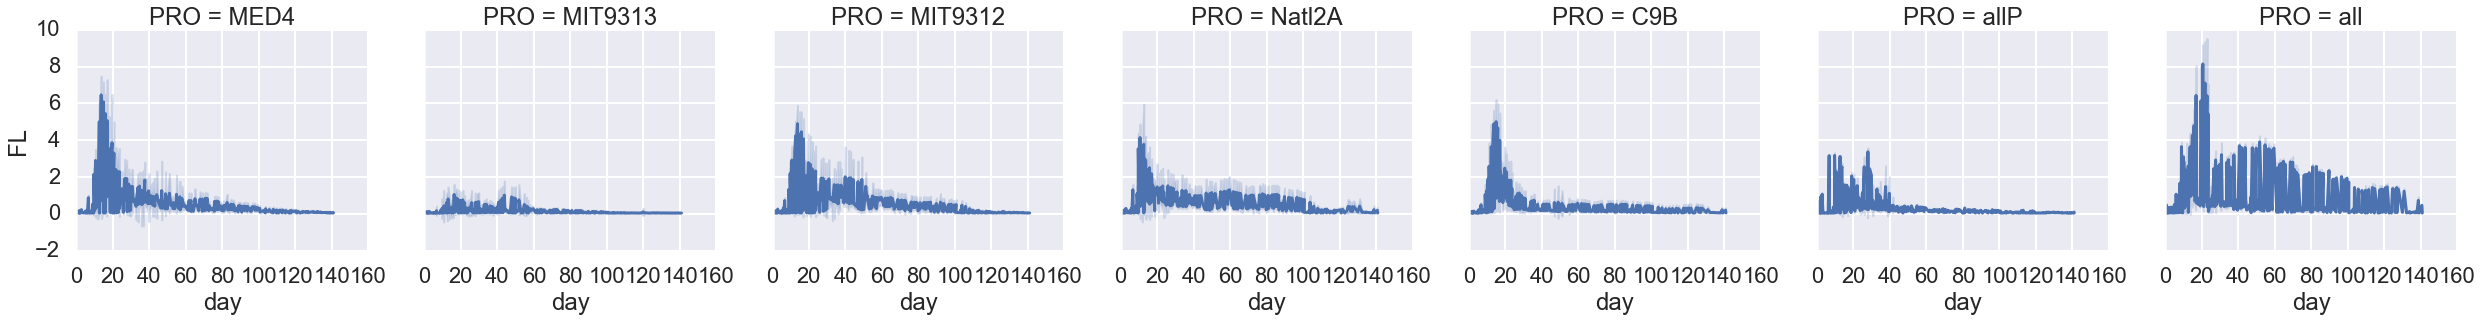

In [10]:
sns.relplot(data=df, x='day', y='FL', kind='line',  col='PRO', ci='sd')

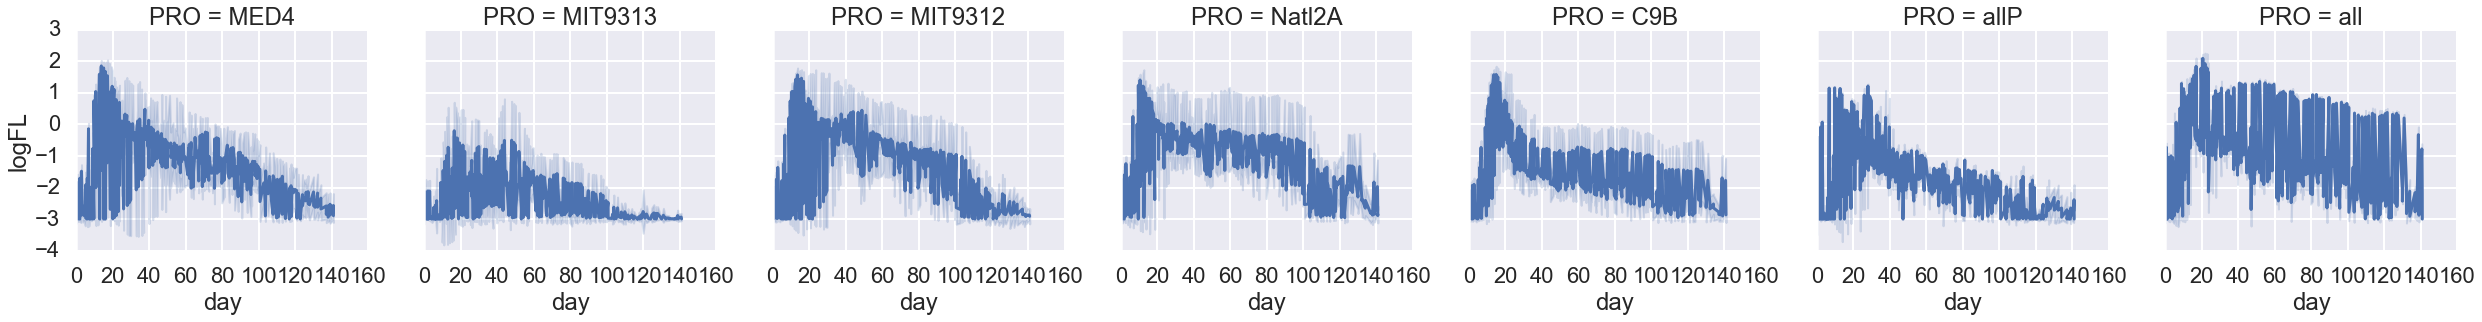

In [11]:
sns.relplot(data=df, x='day', y='logFL', kind='line',  col='PRO', ci='sd')

In [12]:
d = cp.generate_decay(df3, scale=False)

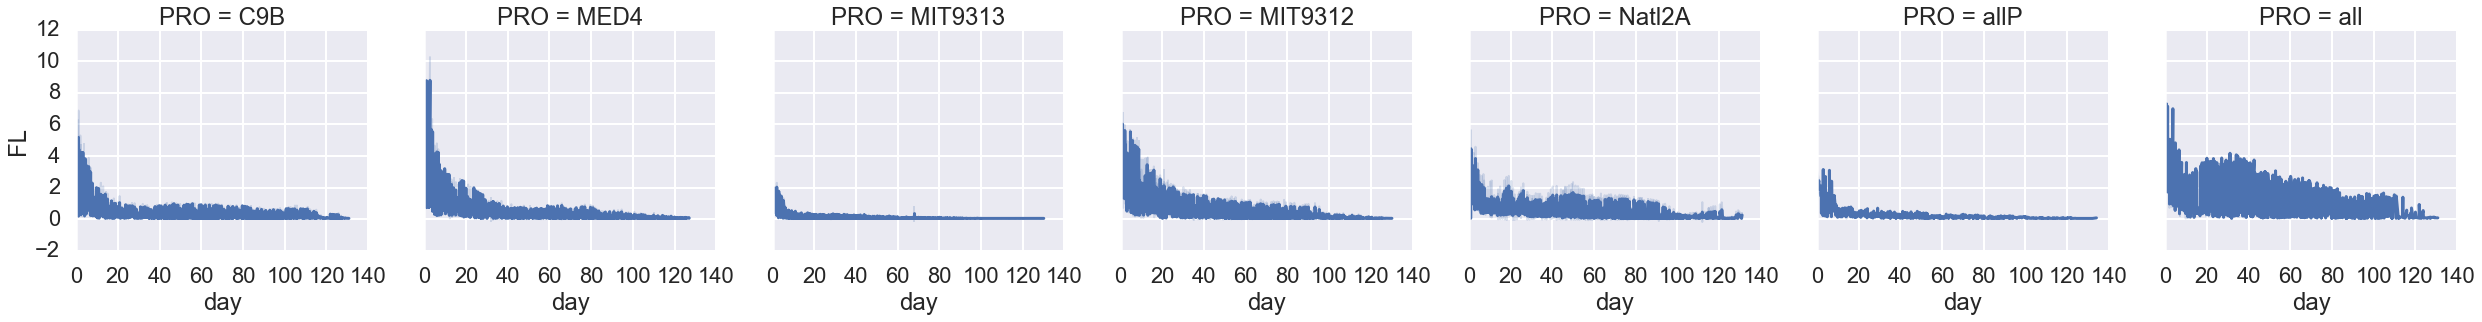

In [13]:
sns.relplot(data=d, x='day', y='FL', kind='line',  col='PRO', ci='sd')

In [14]:
def apply_fit(df, model, print_popt=True):
    x = df['day']
    y = df['FL']
    p0= [0.5, 0.5,0.5,0.5]
    y_pred = 0
    y_pred_p0 = 0
    score = 0
    popt = []
    score_p0 = 0
    popt_p0 = []
    
    try:
        popt, pcov = curve_fit(model, x, y, method='dogbox', loss='soft_l1', f_scale=0.1, #p0=p0
                              # bounds = (0, np.inf)
                              )
        y_pred = model (x, *popt)
        score = r2_score(y, y_pred)
        
    except Exception as e:
        print(e)

    try:
        popt_p0, pcov_p0 = curve_fit(model, x, y, method='dogbox', loss='soft_l1', f_scale=0.1, p0=p0
                              # bounds = (0, np.inf)
                              )
        y_pred_p0 = model (x, *popt)
        score_p0 = r2_score(y, y_pred)
        
    except Exception as e:
        print(e)

    if score_p0 > score:
        score = score_p0
        y_pred = y_pred_p0
        popt = popt_p0
    
        
    if print_popt:
        print(popt)

    df['y_pred'] = y_pred
    for i in range(len(popt)):
        df[f'popt_{i}'] = popt[i]

        
    return df


In [15]:
def apply_fit_2(df, model):
    x = df['day']
    y = df['FL']
    popt, pcov = curve_fit(model, x, y, #method='dogbox', loss='soft_l1', f_scale=0.1, 
                          # bounds = (0, np.inf)
                          )
    y_pred = model (x, *popt)
    print(popt)
    df['y_pred'] = y_pred
    return df


In [16]:
# fit all functions
functions = {'cubic' : cp.model_cubic, 
             'exponential' :cp.model_exponential,
             'hyperbolic' : cp.model_hyperbolic,
             #'exponential_segmented' : cp.model_exponential_segmented,
             'gompertz' : cp.model_gompertz,
             'harmonic' : cp.model_harmonic,
             'linear' : cp.model_linear,
             'logistic3' : cp.model_logistic3,
             'logistic4' : cp.model_logistic4,
             'loglogistic' : cp.model_loglogistic,
             'rodbard4' : cp.model_rodbard4,
             'scurve' : cp.model_scurve,
            }
dfe = d.loc[:, ['day', 'experiment_sample', 'experiment', 'PRO', 'ALT', 'sample', 'culture', 'FL']]
for n in method_cols:
    f = functions[n]
    print(n)
    t = dfe.groupby('experiment_sample').apply(lambda x: apply_fit(x, f))
    dfe[n] = t['y_pred']


cubic
[-3.06609614e-06  6.60486092e-04 -4.64271485e-02  1.48451566e+00]
[-3.06609614e-06  6.60486092e-04 -4.64271485e-02  1.48451566e+00]
[-2.59571165e-06  5.41998247e-04 -3.88069033e-02  1.44485781e+00]
[-2.62367446e-06  5.36007720e-04 -3.64265593e-02  1.25661293e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[-8.06317448e-06  1.79953698e-03 -1.29119592e-01  3.26472410e+00]
[-6.98963862e-06  1.52513284e-03 -1.06796144e-01  2.67749720e+00]
[-6.45387822e-06  1.47249798e-03 -1.10470424e-01  2.99969093e+00]
[-2.16220128e-06  4.17354163e-04 -2.76010811e-02  7.13868928e-01]
[-1.92209441e-06  3.63383136e-04 -2.37645175e-02  6.31798336e-01]
[-1.50706377e-06  3.02758990e-04 -2.20678541e-02  6.65189587e-01]
[-5.31470338e-06  1.21685727e-03 -1.00127172e-01  3.46565173e+00]
[-3.94778382e-06  1.01439367e-03 -9.60016882e-02  3.65050104e+00]
[-6.78069722e-06  1.56221419e-03 -1.21574489e-01  3.62556197e+00]
[-4.45595032e-04  1.36785001e-02  3.49796837e+00 -

Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[-5.91742453e-04  3.07164532e-02 -5.11695156e-01  3.40851963e+00]
[-4.68594604e-04  2.65678313e-02 -4.85740400e-01  3.42984815e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[-7.59586996e-04  3.94989430e-02 -6.69748308e-01  3.92875559e+00]
[-1.21088881e

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[-4.06891568e-04  1.95179291e-02 -2.92066505e-01  1.38282802e+00]
[-4.94474873e-04  2.35932673e-02 -3.50654664e-01  1.63899933e+00]
[-7.76505079e-04  3.30110516e-02 -4.28022167e-01  1.69924578e+00]
[-8.88926766e-04  4.22049686e-02 -6.30137303e-01  3.39911768e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[-4.68438484e-04  2.58038129e-02 -4.

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[-2.21481309e-06  5.26916895e-04 -4.11300356e-02  1.19065630e+00]
[-2.77770728e-06  6.23390949e-04 -4.46318058e-02  1.16072010e+00]
[-2.93643944e-06  6.83631560e-04 -5.11458240e-02  1.35013911e+00]
[-2.36937641e-06  5.39378526e-04 -3.80037554e-02  9.10844312e-01]
[-2.21203169e-06  5.20662993e-04 -3.81761026e-02  9.39419335e-01]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[-8.53452940e-07  2.72104996e-04 -3.16079599e-02  1.48131576e+00]
[ 3.13355933e-08 -4.62113222e-06 -1.10415761e-03  1.85165527e-01]
[-2.82810799e-07  7.53670834e-05 -7.10470469e-03  3.01739685e-01]
[ 3.49297366e-07 -7.58364310e-05  3.39467615e-03  1.26713429e-01]
[ 3.41696777e-07 -1.30623199e-04  5.29007731e-03  6.9317

[-2.21810289e-06  4.08984559e-04 -2.31308340e-02  7.75727220e-01]
[-1.12363897e-06  2.50525082e-04 -1.76988877e-02  5.08357234e-01]
[-5.98963278e-07  1.27181070e-04 -7.94963892e-03  1.86956944e-01]
[-7.33594018e-07  1.56296391e-04 -9.79964951e-03  2.21349967e-01]
[-2.44679841e-06  5.54498773e-04 -4.03372111e-02  1.09310522e+00]
[-2.26999825e-06  5.02908030e-04 -3.52507566e-02  9.45167915e-01]
[-1.31946782e-06  2.87739858e-04 -2.21215722e-02  9.67570308e-01]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[-1.77043789e-06  3.80787030e-04 -2.58292094e-02  7.06676217e-01]
[-1.69909854e-06  3.71716110e-04 -2.60267910e-02  7.37972847e-01]
[-1.85789603e-06  4.07763292e-04 -2.85641745e-02  8.1809

[-1.07199199e-05  1.90202452e-03 -1.11924420e-01  2.25647142e+00]
[-1.65321538e-05  2.12373342e-03 -9.10486275e-02  1.52019065e+00]
[-3.24058700e-06  6.41046469e-04 -5.08710962e-02  1.76592001e+00]
[-5.53058910e-06  9.69745055e-04 -6.36274927e-02  1.95818353e+00]
[-3.34214046e-06  6.49346312e-04 -4.05601349e-02  9.50091852e-01]
[-2.50936482e-06  4.94233412e-04 -3.24987936e-02  8.67872192e-01]
[-3.88783762e-06  7.44955743e-04 -4.60666532e-02  1.08847954e+00]
[-2.77287468e-06  5.56470191e-04 -3.85074947e-02  9.83279330e-01]
[-7.45393879e-06  1.28325781e-03 -7.26326038e-02  1.44686646e+00]
[-6.71910807e-06  1.18811104e-03 -6.93927362e-02  1.44715141e+00]
[-6.49785242e-07  1.25114904e-04 -8.01247140e-03  2.24654398e-01]
[-3.80366634e-06  6.48629796e-04 -3.55713743e-02  6.89067695e-01]
[-3.21008127e-06  5.31495784e-04 -2.73598504e-02  4.90299895e-01]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of func

[-3.34739738e-06  7.69236183e-04 -5.97266136e-02  1.66661459e+00]
[-4.98443377e-07  1.42060895e-04 -1.28645652e-02  4.24789292e-01]
[-4.27557114e-06  8.30366004e-04 -5.00240520e-02  9.75976657e-01]
[-2.60088674e-06  5.11003160e-04 -3.24468096e-02  7.83234535e-01]
[-5.12612669e-07  2.18624314e-04 -2.37646550e-02  8.08222569e-01]
[ 5.80006853e-07  9.49788293e-06 -1.67694583e-02  1.05512941e+00]
[-3.38442753e-07  2.23098836e-04 -3.29809012e-02  1.44963456e+00]
[-2.95691572e-06  5.40723453e-04 -3.12144678e-02  6.18889549e-01]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[-2.17514948e-06  4.19372825e-04 -2.59292291e-02  5.66694858e-01]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[-7.75558444e-07  3.45699661e-04 -3.97863124e-02  1.39690693e+00]
[-2.32164932e-06  4.58620953e-04 -2.98723911e-02  6.95251278e-01]
[-4.57269838e

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


exponential
[4.55546502 0.22042529 0.43229707 1.        ]

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[4.55546502 0.22042529 0.43229707 1.        ]
[4.93645304 0.26959273 0.50600602 1.        ]
[5.01663039 0.27276777 0.44031192 1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[6.39987512 0.11353762 0.30311539 1.        ]
[5.97862836 0.1337708  0.29582354 1.        ]
[5.87097497 0.11684886 0.30335566 1.        ]
[1.76626472 0.16598258 0.11800778 1.        ]
[1.7506149  0.17124688 0.11696164 1.        ]
[1.65786636 0.14535988 0.11972145 1.        ]
[3.41811652 0.02865761 0.03975169 1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 3.73335871  0.02735657 -0.04260412  1.        ]
[3.67755208 0.04536567 0.22987269 1.        ]
[3.36593907 0.22189074 0.9018543  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[3.98111193 0.34183117 1.26271012 1.        ]
[3.89444088 0.35797046 1.27973354 1.        ]
[4.05190432 0.14477995 0.44392825 1.        ]
[4.57605114 0.13293608 0.46341815 1.        ]
[3.87260676 0.13686111 0.41399377 1.        ]
[5.58859261 0.06090381 0.30534552 1.        ]
[6.51074738 0.09129235 0.35153467 1.        ]
[4.80772739 0.05352605 0.1548271  1.        ]
[1.13118242 0.11769488 0.08064878 1.        ]
[1.23259088 0.10014769 0.08936228 1.        ]
[1.66630995 0.22146312 0.10275195 1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[4.31281494 0.31491425 0.41600666 1.        ]
[4.29459298 0.03225005 0.07072627 1.        ]
[3.62240379 0.04710513 0.32411374 1.        ]
[3.56697361 0.30262483 1.26381888 1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[3.54117001 0.16671458 1.08270967 1.        ]
[ 3.09885046  0.00999215 -0.82320369  1.        ]
[9.80659902 0.17136478 0.51362728 1.        ]
[9.26065495 0.13204023 0.58634961 1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[6.09969491 0.08957816 0.60483327 1.        ]
[5.67638734 0.14877769 0.23353375 1.        ]
[6.23187511 0.18319903 0.28063497 1.        ]
[5.47931002 0.16551145 0.29759145 1.        ]
[4.11009631 0.0654308  0.4337594  1.        ]
[4.24440389 0.07807883 0.38972037 1.        ]
[4.29342689 0.07804545 0.4530909  1.        ]
[2.52404011 0.29293327 0.18957352 1.        ]
[1.89396373 0.33213161 0.14350982 1.        ]
[1.64200995 0.24639002 0.17284817 1.        ]
[ 2.97155812  0.01446958 -0.43357845  1.        ]
[ 4.11747585  0.00984961 -1.21208009  1.        ]
[ 8.95657401e+00  2.51285007e-03 -6.54923265e+00  1.00000000e+00]
[2.26322823 0.24044841 1.03884881 1.        ]
[2.77937559 0.27110087 0.81781233 1.        ]
[2.54026639 0.33264041 0.88103558 1.        ]
[3.1913894  0.26533751 0.44591192 1.        ]
[6.0374808  0.27753174 0.04561236 1.        ]
[5.41634413 0.26240888 0.04661322 1.        ]
[5.86104793 0.27685589 0.04766434 1.        ]
[5.51798446 0.23410114 0.04382181 1.        ]
[8.092

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[8.42530176 0.22633404 0.04132408 1.        ]
[7.67916859 0.20091069 0.0430761  1.        ]
[7.54618219 0.22002896 0.04161584 1.        ]
[3.03343483 0.1398085  0.18961775 1.        ]
[3.02460458 0.10162299 0.20054156 1.        ]
[7.78053001 0.38268005 2.05790917 1.        ]
[6.14974437 0.33157453 2.24818492 1.        ]
[5.63824241 0.16551015 2.24152423 1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[5.46930334 0.04817914 0.38370993 1.        ]
[5.40613598 0.0545384  0.40263664 1.        ]
[4.40166511 0.15145181 0.96079986 1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[6.44774001 0.21060278 1.42417566 1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[3.19123266 0.10841165 1.05452946 1.        ]
[6.20519535 0.16940365 0.76623718 1.        ]
[6.04661468 0.14034145 0.76528826 1.        ]
[6.97378595 0.1600527  0.68984177 1.        ]
[4.71442378 0.08206204 0.34853853 1.        ]
[5.0499925  0.08985128 0.29409193 1.        ]
[4.53870627 0.07750235 0.32988804 1.        ]
[1.31857786 0.13629774 0.10228414 1.        ]
[2.4147915  0.28649428 0.14827685 1.        ]
[2.13945882 0.31537707 0.17096649 1.        ]
[3.96404202 0.07455662 0.82599755 1.        ]
[5.00968768 0.10566659 0.86511433 1.        ]
[3.71383332 0.08851894 0.79690918 1.        ]
[3.70208133 0.46451383 1.24864799 1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[4.01163932 0.50708057 1.15027271 1.        ]
[3.86148802 0.50010919 1.16682793 1.        ]
[4.53952532 0.22869437 0.11639444 1.        ]
[4.18524365 0.26709467 0.16161654 1.        ]
[4.43762371 0.26584993 0.14387291 1.        ]
[5.18272691 0.21228237 0.39980958 1.        ]
[5.90486577 0.20640191 0.33510641 1.        ]
[5.05618654 0.27650098 0.48172729 1.        ]
[1.60452402 0.28914936 0.05783608 1.        ]
[1.66576924 0.30794675 0.05760915 1.        ]
[1.43467093 0.2945447  0.08845915 1.        ]
[3.01969187 0.11218532 0.54344968 1.        ]
[3.20281231 0.10587811 0.52482702 1.        ]
[ 3.42518769  0.06351325 -0.0097671   1.        ]
[3.56119529 0.31808329 0.63010775 1.        ]
[3.97195456 0.29718677 0.59422637 1.        ]
[4.31655476 0.29757765 0.53968158 1.        ]
[ 5.37647922  0.15535979 -0.01456211  1.        ]
[ 5.20330016e+00  1.66091219e-01 -2.84495397e-03  1.00000000e+00]
[3.81950094 0.22883927 0.13441771 1.        ]
[5.47057138 0.35086662 0.75112112 1.        ]
[5.776

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.42485468 0.32697219 0.02389163 1.        ]
[1.68808909 0.3584479  0.02945174 1.        ]
[1.69277119 0.50101396 0.0535545  1.        ]
[3.19589444 0.32519777 0.42522817 1.        ]
[2.59690303 0.1579552  0.81218668 1.        ]
[3.25875069 0.16514811 0.76402701 1.        ]
[2.70990837 0.17013793 0.41537496 1.        ]
[3.06360983 0.23568928 0.48010468 1.        ]
[2.25850064 0.31784439 0.34264046 1.        ]
[2.77313828 0.24384556 0.57969269 1.        ]
[3.98957154 0.29535341 0.54372204 1.        ]
[3.76443843 0.32464361 0.56565304 1.        ]
[ 4.34034859  0.16062898 -0.01262998  1.        ]
[3.31442712 0.23822744 0.14676155 1.        ]
[3.56867048 0.30461648 0.16864772 1.        ]
[5.68845673 0.28667514 0.42488827 1.        ]
[5.24423726 0.31965308 0.44459633 1.        ]
[5.32931009 0.32896927 0.46370743 1.        ]
[ 1.33465981  0.17228866 -0.00893049  1.        ]
[2.03731384 0.49815915 0.0393483  1.        ]
[1.29622069 0.36328621 0.03792489 1.        ]
[3.41006094 0.27849077 0.8

[2.75356427 0.26601016 0.12266283 1.        ]
[1.11787396 0.3890231  0.04827937 1.        ]
[1.02141218 0.37327456 0.04983785 1.        ]
[2.06759076 0.14449514 0.16710915 1.        ]
[1.75907286 0.18020233 0.18272183 1.        ]
[2.85278942 0.19336153 0.36550018 1.        ]
[3.39644399 0.31158833 0.35384899 1.        ]
[3.69829486 0.2738052  0.35779105 1.        ]
[3.12665016 0.2241876  0.15319638 1.        ]
[3.15561322 0.223892   0.15886145 1.        ]
[3.30007342 0.2019579  0.18098484 1.        ]
[3.33178866 0.28249984 0.28547854 1.        ]
[3.16145517 0.28341374 0.2470853  1.        ]
[3.34669585 0.26462217 0.25889682 1.        ]
[2.86266738 0.28725969 0.11957809 1.        ]
[3.26730995 0.19966385 0.11736601 1.        ]
[3.2879561  0.21287    0.12777767 1.        ]
[2.32439413 0.10915474 0.21868488 1.        ]
[3.12124658 0.23897182 0.23395655 1.        ]
[3.20835082 0.29802845 0.22968109 1.        ]
[1.40886509 0.58509079 0.05523577 1.        ]
[1.11680449 0.40230728 0.05598461 

[ 0.66870291  0.01692553 -0.04541838  1.        ]
[ 0.70476795  0.01805778 -0.03964389  1.        ]
[0.97074504 0.05869381 0.00599477 1.        ]
[ 1.10544938  0.02017547 -0.18332616  1.        ]
[ 1.35308423  0.02172711 -0.17819195  1.        ]
[0.21910273 0.18005171 0.0556917  1.        ]
[0.57251752 0.08693831 0.04372595 1.        ]
[0.52101169 0.08866537 0.04231651 1.        ]
[1.57006379 0.11080052 0.05224744 1.        ]
[1.77362896 0.13478149 0.0590287  1.        ]
[1.28158799 0.08141188 0.03889147 1.        ]
[1.91788477 0.04400655 0.00925877 1.        ]
[3.34071833 0.22363562 0.30374526 1.        ]
[1.83596709 0.03956498 0.00584977 1.        ]
[0.27371318 0.03639729 0.03478206 1.        ]
[0.24409844 0.06136355 0.04592575 1.        ]
[0.57682937 0.13876088 0.07480451 1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 3.92442986e+00  3.46812965e-03 -2.81327005e+00  1.00000000e+00]
[ 2.07078596  0.01225894 -0.63420682  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


gompertz
[ 0.42580497 -2.55729968  0.12534421  1.        ]
[ 0.42580497 -2.55729968  0.12534421  1.        ]
[ 0.4903188  -2.43755193  0.13220072  1.        ]
[ 0.42441031 -2.5889636   0.12918491  1.        ]
[ 0.38086073 -2.93926363 16.64025185  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.2526425  -3.27735717  0.05395283  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_gompertz() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]
[ 0.09330973 -3.00620745  0.06052016  1.        ]
[ 0.09313829 -2.99302186  0.06226818  1.        ]
[ 0.17826598 -2.26505713  8.00164604  1.        ]
[ 0.1089772  -3.5837199   0.01173625  1.        ]
[ 1.15862070e-03 -8.14847097e+00  4.13117455e-03  1.00000000e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_gompertz() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]
[ 0.89004018 -1.57138664  0.1356196   1.        ]
[ 1.24781741 -1.43768259  0.22064111  1.        ]
[ 1.26480759 -1.41211248  0.22466286  1.        ]
[ 0.41418174 -2.3957734   0.06963624  1.        ]
[ 0.42544389 -2.49663848  0.06202465  1.        ]
[ 0.46353978 -2.21648769 17.38305     1.        ]
Optimal parameters not found: The maxi

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 1.24825919 -1.35086768  0.17741789  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.41357988 -3.23757745  0.06145987  1.        ]
[ 0.44640892 -3.10534886  0.0471333   1.        ]
[ 0.75793916 -2.54161993  8.21665137  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.29477192 -2.93336735 22.89777211  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.24084273 -3.39646563  0.07086116  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.25209658 -3.20749565  0.06514558  1.        ]
[ 0.31211764 -2.69925318  0.02669329  1.        ]
[ 0.52926638 -2.27642452 16.9516536   1.        ]
[ 0.39429851 -2.56558583  0.03829333  1.        ]
[ 0.16701146 -2.78657025  0.12085004  1.        ]
[ 0.1301301  -2.74683205  0.14116403  1.        ]
[ 0.14675483 -2.51517741  0.10057261  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 1.03594115 -1.15780764  0.16954509  1.        ]
[ 0.81114654 -1.49394408  0.17293527  1.        ]
[ 0.87830163 -1.36269457  0.21860898  1.        ]
[ 0.42968466 -2.13870661  0.12472657  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.03039652 -5.18937371  0.06566377  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.03123847 -5.2405467   0.0689396   1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 4.72744434e-13 -3.00957933e+01  7.76022038e-03  1.00000000e+00]
[ 0.01797752 -5.81373427  0.06777479  1.        ]
[ 0.02045315 -5.66162193  0.06860203  1.        ]
[ 0.01913256 -5.75885856  0.06863777  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.03191524 -4.31370711  0.06378177  1.        ]
[ 0.03030455 -4.47062956  0.06122763  1.        ]
[ 0.03270126 -4.35295931  0.06644648  1.        ]
[ 0.10092514 -3.19860772  0.06577636  1.        ]
[ 0.03217249 -4.26778828  0.04697896  1.        ]
[ 0.21113319 -2.48782383  8.0039492   1.        ]
[ 1.97537155e-13 -3.13841899e+01  7.88485829e-03  1.00000000e+00]
[ 2.07867681e-13 -3.12483958e+01  6.49546931e-03  1.00000000e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.16105605 -3.00215372  0.053362    1.        ]
[ 0.27909326 -2.44092136 10.42630568  1.        ]
[ 2.04360324 -1.57465662  0.23674155  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 2.22991569 -1.32259419  0.20060806  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters no

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 5.41580899e-03 -5.76611661e+00  5.61731185e-02  1.00000000e+00]
[ 0.04113727 -3.62268196  0.08860656  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.31864635 -2.42155065  0.04347886  1.        ]
[ 0.29141219 -2.56059923  0.03973002  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.57823187 -1.98321229  0.16772253  1.        ]
[ 0.51022784 -2.19857053  0.14601133  1.        ]
[ 0.48595009 -2.31266216  0.1505974   1.        ]
[ 0.40153716 -2.45660763  8.5212926   1.        ]
[ 0.33947481 -2.43154071  8.52981282  1.        ]
[ 1.39781702e-03 -7.94549606e+00  2.82839703e-02  1.00000000e+00]
[ 0.66631689 -2.24608158  0.17045503  1.        ]
[ 0.58399622 -2.39862558  0.1556775   1.        ]
[ 2.03669245 -0.07303091  1.          1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[ 3.97526222e-13 -2.89195743e+01  1.08915419e-02  1.00000000e+00]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 4.48363226e-13 -2.89716329e+01  1.18901812e-02  1.00000000e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.36445151 -2.29843891  0.14928299  1.        ]
[ 0.69481156 -1.58523305  0.08450376  1.        ]
[ 0.60617895 -1.89341893  0.07995454  1.        ]
[ 0.59562593 -1.54059338  8.68550119  1.        ]
[ 0.4049526  -2.16921023  0.10956307  1.        ]
[ 0.28766917 -2.21187891  0.15170729  1.        ]
[ 0.49309818 -1.9223285   0.12221281  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.46029196 -2.29110103  0.13912655  1.        ]
[ 0.49116033 -2.17929641  0.15681419  1.        ]
[ 0.27603827 -2.33838697  9.27911897  1.        ]
[ 7.94101722e-04 -8.37167633e+00  2.62726063e-02  1.00000000e+00]
[ 0.03959483 -4.54889923  0.06901777  1.        ]
[ 0.24730587 -3.17716282  0.09586491  1.        ]
[ 0.33380846 -2.82953562  0.12806428  1.        ]
[ 0.35367364 -2.79216598  0.13288623  1.        ]
[ 1.86084565e-13 -2.95891792e+01  6.09815496e-03  1.00000000e+00]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 7.72243847e-04 -7.45437191e+00  4.95094856e-02  1.00000000e+00]
[ 0.86043146 -1.60000117  0.18456128  1.        ]
[ 0.90093316 -1.53065599  0.16960764  1.        ]
[ 0.70635037 -1.86850004  0.1408009   1.        ]
[ 0.39230591 -2.5222393   0.14379134  1.        ]
[ 0.42303239 -2.34720411  0.13618957  1.        ]
[ 0.35982264 -2.29810895  0.10538316  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.01206109 -4.78359943  0.09348443  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 4.13838734e-13 -2.86484900e+01  7.31573964e-03  1.00000000e+00]
[ 0.39189276 -1.72704094  8.43057992  1.        ]
[ 0.09046293 -3.27778282  0.05515205  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.2610302  -2.73009047  0.13253654  1.        ]
[ 0.30953399 -2.46528014  0.13432132  1.        ]
[ 0.39190003 -2.20692805  0.15518817  1.        ]
[ 0.21186563 -2.62250451  0.03574757  1.        ]
[ 0.5719146  -1.6744498   0.07301643  1.        ]
[ 1.14195622 -1.07874306  0.20112844  1.        ]
[ 0.79348438 -1.7589246   0.29282283  1.        ]
[ 0.47660259 -2.26209099  0.17343291  1.        ]
[ 0.63719817 -1.96892457  0.27490936  1.        ]
[ 2.79125098e-05 -1.20517929e+01  1.85668796e-02  1.00000000e+00]
[ 0.14224088 -3.57699949  0.10629298  1.        ]
[ 0.01206423 -6.00696512  0.04607102  1.        ]
[ 0.25694731 -3.08569309  0.0749233   1.        ]
[ 0.25276573 -3.06674889  0.07308324  1.        ]
[ 0.49133806 -2.37490282  0.12740577  1.        ]
[ 0.04566257 -3.48519182  0.12084285  1.        ]
[ 0.07766491 -3.16151568  0.15217925  1.        ]
[ 0.08265574 -3.28033893  0.17335618  1.        ]
[ 1.17717056 -1.37172304  0.52220117  1.        ]
[ 1.33429387 -1.2408132   0.842123

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.07046414 -3.87281975  0.057854    1.        ]
[ 0.19295449 -2.69191789 15.65395656  1.        ]
[ 0.25858357 -2.56063211  0.04649502  1.        ]
[ 0.09854952 -2.38733121  0.23686666  1.        ]
[ 0.08551084 -2.64365611  0.11507321  1.        ]
[ 0.10820333 -2.69260426  0.28384638  1.        ]
[ 0.50110229 -1.79096926  0.18908466  1.        ]
[ 5.82905844e-13 -2.85325684e+01  7.26036355e-04  1.00000000e+00]
[ 6.69692963e-13 -2.81656562e+01  6.36529515e-04  1.00000000e+00]
[ 0.44726404 -1.56354108 16.16575098  1.        ]
[ 0.29454973 -2.22645516  0.13588699  1.        ]
[ 0.3116037  -1.85972547  0.10053236  1.        ]
[ 0.19947448 -1.69671671  0.20573293  1.        ]
[ 0.0506722  -3.02728447  0.0964792   1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.03910982 -3.09091207  0.05636456  1.        ]
[ 0.05275454 -2.74717262  0.11743962  1.        ]
[ 0.08277073 -2.17741968  0.03161662  1.        ]
[ 0.1333003  -1.415494   10.44974159  1.        ]
[ 0.23607644 -1.3933584  15.20407228  1.        ]
[ 0.19213441 -1.69357698 13.70814832  1.        ]
[ 0.20864999 -1.80847346 16.83820167  1.        ]
[ 0.30353544 -1.8309479  21.81640101  1.        ]
[ 0.11041929 -3.09938371  0.03564896  1.        ]
[ 0.18805763 -2.73973586  0.05031324  1.        ]
[ 0.17065795 -2.34889016  0.0460135   1.        ]
[ 0.08539958 -3.0326473   0.0373015   1.        ]
[ 0.22837096 -1.80031568 32.91177313  1.        ]
[ 0.16194193 -1.8955537   0.08723544  1.        ]
[ 0.14245811 -2.00973151  0.08596458  1.        ]
[ 0.1656427  -2.51293346  0.09548113  1.        ]
[ 0.01566835 -4.42706979  0.00692403  1.        ]
[ 0.06940526 -2.98818815  0.01627928  1.        ]
[ 0.02982095 -3.6933661   0.00887503  1.        ]
[ 0.07152728 -2.03681939  0.06890618  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.18646951 -2.56465164  0.02633114  1.        ]
[ 0.13060372 -2.89859715  0.0253134   1.        ]
[ 0.20607926 -2.51427424  0.10952038  1.        ]
[ 0.15711802 -2.94423675  0.05356301  1.        ]
[ 0.22830649 -2.36941456  0.06824538  1.        ]
[ 0.10438977 -3.05835461  0.06901625  1.        ]
[ 0.09099602 -2.78991607  0.05806601  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.1072407  -2.97444546  0.06298404  1.        ]
[ 0.25503012 -2.38144018  0.04974987  1.        ]
[ 0.18436691 -2.53679342  0.03664512  1.        ]
[ 0.21081368 -2.75507755  0.03634125  1.        ]
[ 0.05200121 -2.07879092  0.09081362  1.        ]
[ 0.05464672 -3.01778077  0.09830755  1.        ]
[ 0.0497539  -2.57657818  0.21588052  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.15983919 -2.28177516  0.0312138   1.        ]
[ 0.01662138 -5.0447545   0.00871574  1.        ]
[ 0.12417664 -2.8358024   0.01667037  1.        ]
[ 0.23615158 -1.74287671  0.03534711  1.        ]
[ 0.31398643 -2.04504406  0.11495069  1.        ]
[ 0.27202125 -2.10282819  0.17792599  1.        ]
[ 0.12158696 -3.45973419  0.10794521  1.        ]
[ 0.10778829 -3.5758661   0.08880963  1.        ]
[ 0.11700295 -3.52509107  0.09433613  1.        ]
[ 0.09482291 -2.92356745  0.07241102  1.        ]
[ 0.12973698 -3.06757064  8.08820829  1.        ]
[ 0.14448726 -3.0375002  21.82998955  1.        ]
[ 0.19162619 -3.00546009  0.07738327  1.        ]
[ 0.21985361 -2.89787004  0.11182348  1.        ]
[ 0.21624338 -2.83315363  0.10670923  1.        ]
[ 0.06144203 -2.60333946  0.09948427  1.        ]
[ 0.05664807 -2.69001964  0.07210823  1.        ]
[ 0.06943074 -2.70373196  0.20753398  1.        ]
[ 0.32645466 -2.14357198  0.07003798  1.        ]
[ 0.11325331 -3.06999248  0.02492262  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.1348184  -3.18952815  0.08252753  1.        ]
[ 0.14048951 -3.16002741  0.08226508  1.        ]
[ 0.21695699 -2.75418174 10.03035104  1.        ]
[ 0.26720251 -2.60707389  0.12098876  1.        ]
[ 0.22821584 -2.70575345  0.11976104  1.        ]
[ 0.23999674 -2.71324911  0.1094661   1.        ]
[ 0.10961829 -3.32912725  0.10280079  1.        ]
[ 0.1435699  -3.07330264 11.1170231   1.        ]
[ 0.14932118 -3.07877107 12.1173754   1.        ]
[ 0.18794298 -2.62370999  0.04688249  1.        ]
[ 0.2180536  -2.74702005  0.10442258  1.        ]
[ 0.21906423 -2.75880964  0.13324336  1.        ]
[ 0.05353125 -3.2999547   0.233725    1.        ]
[ 0.05344306 -3.07743313  0.15879438  1.        ]
[ 0.06457456 -3.36127996  0.2972113   1.        ]
[ 0.25319817 -2.53776586  0.10169577  1.        ]
[ 0.29600752 -2.59728459  0.10997412  1.        ]
[ 0.32850275 -2.45682679  0.14054506  1.        ]
[ 0.24137891 -1.97061875  0.1081798   1.        ]
[ 0.13466004 -2.37691571  0.03046019  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.200428   -2.94560055  0.14130975  1.        ]
[ 0.08077342 -3.97172428  0.02815514  1.        ]
[ 0.1939287  -3.16250252  0.04793887  1.        ]
[ 1.34865368  0.0664758  -0.03739175  1.        ]
[ 5.93744881e-13 -2.87500000e+01  8.65295814e-04  1.00000000e+00]
[ 0.1420937  -2.86019015  0.03208864  1.        ]
[ 0.0532091  -3.42063007  0.05523069  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 0.02534556 -4.49766626  0.03744886  1.        ]
[ 0.20857002 -2.66542585 10.06874835  1.        ]
[ 7.18129039e-13 -2.83400110e+01  1.72089584e-03  1.00000000e+00]
[ 0.01822626 -4.84047825  0.01035689  1.        ]
[ 0.07275502 -3.29523479  0.11398997  1.        ]
[ 0.06523561 -3.29760609  0.09611459  1.        ]
[ 0.05635435 -3.32020033  0.0910311   1.        ]
[ 0.30053514 -2.612447    0.19116255  1.        ]
[ 0.16273975 -3.31031003  0.14726029  1.        ]
[ 0.40345857 -1.7684595  16.22038438  1.        ]
Optimal parameters not found: Th

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.11888394 -3.25000489  0.07305028  1.        ]
[ 0.02883269 -4.90020313  0.02216869  1.        ]
[ 0.01036331 -5.01575745  0.00829928  1.        ]
[ 0.03112084 -4.26097794  0.01158852  1.        ]
[ 0.16825167 -3.07364691  0.05491507  1.        ]
[ 0.22096387 -2.16882926  8.14294411  1.        ]
[ 0.09149748 -3.18316067  0.03957626  1.        ]
[ 0.13941851 -3.39144454  0.08883248  1.        ]
[ 1.41463857e-03 -7.65816402e+00  5.98323893e-03  1.00000000e+00]
[ 0.00690403 -6.01726595  0.0109828   1.        ]
[ 0.38000271 -2.33578037  0.08766656  1.        ]
[ 0.09394843 -2.68872818  0.08701906  1.        ]
[ 0.08751454 -2.50755805  0.08911285  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.10898644 -3.24327465  0.05580795  1.        ]
[ 0.10441858 -3.43719503  0.03875845  1.        ]
[ 0.03649702 -4.43771881  0.0272223   1.        ]
[ 0.14787

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.52269941 -1.64051792  8.92502673  1.        ]
[ 0.31379864 -2.36387561  0.06290416  1.        ]
[ 0.36687408 -2.35882944  8.26738602  1.        ]
[ 0.02503437 -2.34359155  0.03179203  1.        ]
[ 0.03859931 -2.79246895  0.05547579  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 1.42550498e-03 -7.00350344e+00  7.81191347e-03  1.00000000e+00]
[ 0.20776464 -2.66519117  0.08806195  1.        ]
[ 0.12079611 -2.73767481  0.03818213  1.        ]
[ 0.06430122 -3.4850866   0.03229983  1.        ]
[ 0.15007426 -3.03523402  0.07507793  1.        ]
[ 0.18385519 -2.84608768  0.12878477  1.        ]
[ 0.05650271 -2.82757572  0.05694514  1.        ]
[ 0.05763253 -3.43034845  0.05677075  1.        ]
[ 0.1875386  -2.25821833 13.45930379  1.        ]
[ 0.38301161 -2.14816653  0.12147477  1.        ]
[ 0.29925349 -2.50063727  0.11680663  1.        ]
[ 0.26592266 -2.7382919   0.09940523  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 0.54658431 -1.59953824 17.100498

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.24256368 -1.90261401  8.68391162  1.        ]
[ 0.06345134 -3.21703199  0.02112223  1.        ]
[ 0.09106644 -3.41157237  0.04991086  1.        ]
[ 0.03519976 -2.37329335  0.03824458  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.0238124  -2.82489807  0.02755803  1.        ]
[ 0.05577557 -3.76221021  0.0649164   1.        ]
[ 0.05368612 -3.63953385  0.04920861  1.        ]
[ 0.24221464 -1.8947861   8.24291146  1.        ]
[ 0.12472702 -2.77994883  0.06591968  1.        ]
[ 0.09879715 -3.02806057  0.04564441  1.        ]
[ 0.05710909 -3.52251963  0.01939304  1.        ]
[ 0.1429188  -2.84201366  0.05032065  1.        ]
[ 0.12359569 -3.09931679  0.03882862  1.        ]
[ 0.29510576 -2.52421579  0.15760035  1.        ]
[ 0.33901786 -1.94543596  8.78524193  1.        ]
[ 0.20488104 -2.42383302  0.05929068  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.14248233 -2.47375595  0.10651967  1.        ]
[ 0.12558607 -2.92988055  0.0863625   1.        ]
[ 0.11791272 -2.99368953  0.07719055  1.        ]
[ 0.31884755 -2.4825384   0.10421853  1.        ]
[ 0.2325751  -2.95574866  0.09945205  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_gompertz() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]
[ 0.05672627 -3.26920809  0.07895878  1.        ]
[ 0.03449238 -3.29611179  0.03636449  1.        ]
[ 5.02784882e-13 -2.89147068e+01  1.20661951e-03  1.00000000e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.40854707 -1.60170502  8.20079742  1.        ]
[ 0.39508467 -2.02728259  0.06944797  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.2802116  -2.20082154  0.09666434  1.        ]
[ 0.28025665 -2.24754733  0.09417839  1.        ]
[ 0.26248063 -1.22887856 18.78329887  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 0.28178117 -1.11812573 10.61239133  1.        ]
[ 4.04202310e-03 -5.17697113e+00  4.88225215e-03  1.00000000e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_gompertz() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_gompertz() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]
[ 3.43383912e-13 -2.89891859e+01  1.17195566e-03  1.00000000e+00]
[ 0.05435918 -1.66277961  0.11259341  1.        ]
[ 0.02676206 -3.16199032  0.03053771  1.        ]
[ 0.02563085 -3.10059292  0.03062483  1.        ]
[ 0.0362624  -3.83504415  0.03740229  1.        ]
[ 0.04193374 -3.79601271  0.04463797

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 0.01580585 -4.44465143  0.02219276  1.        ]
[ 0.12149185 -3.32747412  0.06022246  1.        ]
[ 0.27380926 -2.61892108  0.09763746  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.01643441 -2.9465852   0.01224404  1.        ]
[ 0.0379876  -2.05038111  0.03006973  1.        ]
[ 0.06558418 -2.31164003  0.06198229  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 4.80868666e-13 -2.85682010e+01  8.01511271e-04  1.00000000e+00]
[ 4.30916497e-13 -2.89352620e+01  9.39637632e-04  1.00000000e+00]
[ 4.57797926e-13 -2.88878670e+01  1.01897281e-03  1.00000000e+00]
[ 3.20594744e-04 -7.02140985e+00  4.98690135e-03  1.00000000e+00]
[ 0.08314829 -2.49903124  0.10649559  1.        ]
[ 1.66080146e-08 -1.69293153e+01  2.02283870e-03  1.00000000e+00]
[ 3.02446994e-13 -2.91599752e+01  1.63557714e-03  1.00000000e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 8.65865325e-13 -2.84484732e+01  7.24143549e-04  1.00000000e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 4.46979735e-13 -2.85426083e+01  1.28775753e-03  1.00000000e+00]
[ 0.01217821 -4.55536034  0.00955031  1.        ]
[ 0.06640675 -3.17803615  0.02457096  1.        ]
[ 0.0973273  -3.3504903   0.03245202  1.        ]
[ 1.51119628e-03 -5.65917338e+00  6.64049893e-03  1.00000000e+00]
[ 0.04369251 -3.6165251   0.04189786  1.        ]
[ 0.17823572 -1.71156312 13.03392809  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 4.88261962e-13 -2.84912645e+01  9.98839703e-04  1.00000000e+00]
[ 3.51597243e-13 -2.91661526e+01  1.20057689e-0

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


[ 5.23667860e-13 -2.81541207e+01  8.21772671e-04  1.00000000e+00]
[ 0.09587454 -2.34862311  0.03869123  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.03210287 -2.76227505  0.02927327  1.        ]
[ 0.04318037 -1.80588214  0.03447596  1.        ]
[ 0.07638651 -2.42863867  0.07015391  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 0.18803473 -2.5090281   0.19717251  1.        ]
[ 0.12343254 -3.10044109  0.14320715  1.        ]
[ 0.12220578 -2.93739774  0.11975053  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 3.80580140e-03 -6.20118884e+00  1.11218584e-02  1.00000000e+00]
[ 0.0476866  -3.76916605  0.02420182  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.03780733 -3.16672972  0.01756371  1.        ]
[ 0.06131

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:214: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_gompertz() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]
[ 0.17521256 -3.05623454  0.07917622  1.        ]
[ 0.4442904  -2.25879317  0.16078478  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


harmonic
[5.39901065 0.56438542 0.25549181 1.        ]
[5.39901065 0.56438542 0.25549181 1.        ]
[5.4207982  0.48477249 0.28394953 1.        ]
[5.55004657 0.54201254 0.22568935 1.        ]
[ 7.99700124  0.25178083 -0.17128379  1.        ]
[ 7.22852078  0.32933856 -0.05565423  1.        ]
[ 7.46834097  0.28570603 -0.09096314  1.        ]
[ 1.90083405  0.29053691 -0.00914034  1.        ]
[1.84801884e+00 3.10501218e-01 2.80819421e-04 1.00000000e+00]
[ 1.75217982  0.24846276 -0.00853186  1.        ]
[ 4.71674968  0.05276865 -0.47462     1.        ]
[ 5.05787045  0.03972071 -0.79955884  1.        ]
[ 4.87942735  0.07085001 -0.41409024  1.        ]
[3.58716202 0.40896272 0.73359245 1.        ]
[4.15075622 0.65498955 1.10207045 1.        ]
[4.04914883 0.85310176 1.14932847 1.        ]
[4.40755774 0.28977574 0.2065653  1.        ]
[4.98950795 0.26653299 0.1899586  1.        ]
[4.54171607 0.29220444 0.19190334 1.        ]
[ 7.69631098  0.12681235 -0.32479014  1.        ]
[ 7.66939811  0.164

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[ 1.60396922  0.41069292 -0.17393224  1.        ]
[ 1.92168125  0.4981271  -0.17594493  1.        ]
[ 1.77969042  0.97163293 -0.06334771  1.        ]
[3.33090318 0.41259277 0.03276749 1.        ]
[3.18085404 0.16104991 0.18212486 1.        ]
[3.99245214 0.17770507 0.01580457 1.        ]
[ 3.08687065  0.15421571 -0.21970011  1.        ]
[3.51164455 0.2986588  0.01876912 1.        ]
[2.52635947e+00 4.04770269e-01 2.10129435e-03 1.00000000e+00]
[3.25362492 0.31553868 0.13331744 1.        ]
[4.4946436  0.45832508 0.07288924 1.        ]
[4.20698901 0.50825867 0.14675198 1.        ]
[ 4.2976997   0.10828232 -1.14915456  1.        ]
[ 4.0213113   0.26394048 -0.50910218  1.        ]
[ 3.96238429  0.39089468 -0.31540319  1.        ]
[ 5.72408192  0.36160912 -0.315377    1.        ]
[ 5.73893028  0.51440824 -0.1231686   1.        ]
[ 5.84746983  0.52793293 -0.11282154  1.        ]
[ 1.53797084  0.16622033 -0.31260573  1.        ]
[ 2.1261925   1.28240798 -0.0672199   1.        ]
[ 1.47397868  0.

[0.83559386 0.48371578 0.03249906 1.        ]
[0.85283024 0.32341671 0.01738634 1.        ]
[0.99965943 0.96041061 0.04654789 1.        ]
[2.66471304 0.22133932 0.16325829 1.        ]
[ 2.58046112  0.11192476 -0.0821728   1.        ]
[2.66960462 0.23260912 0.19157343 1.        ]
[1.79884785 0.30716468 0.2147441  1.        ]
[1.40941526 0.27543257 0.18427521 1.        ]
[1.68759214 0.49881147 0.265025   1.        ]
[2.810496   0.71081528 0.04620007 1.        ]
[1.06387741 0.99730478 0.02485935 1.        ]
[0.99931052 0.82060977 0.02427703 1.        ]
[2.28596036 0.25313533 0.02542697 1.        ]
[1.95726925 0.30147142 0.07074083 1.        ]
[2.98380432 0.39514109 0.2279374  1.        ]
[3.59508011 0.5412769  0.21845419 1.        ]
[3.96660267 0.52174089 0.20246444 1.        ]
[3.20211269 0.51057572 0.03940769 1.        ]
[3.25434273 0.48104758 0.03691339 1.        ]
[3.36929177 0.49801692 0.06051271 1.        ]
[3.47309885 0.55863284 0.15209571 1.        ]
[3.30447265 0.5496457  0.11312

[2.38105749 0.39953364 0.01960418 1.        ]
[2.35819692 0.36124967 0.00914741 1.        ]
[3.68827487 0.45886984 0.17041769 1.        ]
[4.45338027 0.47914177 0.04522618 1.        ]
[4.15479461 0.64154166 0.17657072 1.        ]
[ 1.53650742  0.41491525 -0.02537576  1.        ]
[ 0.99963218  0.15182    -0.06422193  1.        ]
[ 3.06125881  0.01599021 -1.32828605  1.        ]
[ 2.38102828  0.02832325 -0.77600983  1.        ]
[ 2.12266236  0.0830752  -0.13742972  1.        ]
[2.88444558 0.20447571 0.14000453 1.        ]
[2.45188642 0.32469751 0.11935572 1.        ]
[2.55296107 0.26555456 0.09942095 1.        ]
[0.82881059 0.06742184 0.01035266 1.        ]
[ 0.8806629   0.02019663 -0.20467293  1.        ]
[0.99186686 0.0940584  0.04127581 1.        ]
[ 1.23224436  0.06966668 -0.20879925  1.        ]
[ 1.69354876  0.01363814 -0.77744774  1.        ]
[ 1.92893141  0.01813268 -0.72485129  1.        ]
[0.25933952 0.36899666 0.04090758 1.        ]
[ 0.6890907   0.12332786 -0.03961686  1.    

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


linear
[-0.00514355  0.8039574   1.          1.        ]
[-0.00514355  0.8039574   1.          1.        ]
[-0.00619396  0.93619736  1.          1.        ]
[-0.00525681  0.80797738  1.          1.        ]
[-0.01089537  1.1768473   1.          1.        ]
[-0.00942712  1.04748562  1.          1.        ]
[-0.01282669  1.33960439  1.          1.        ]
[-0.00423877  0.3686103   1.          1.        ]
[-0.0035244   0.32490563  1.          1.        ]
[-0.00429754  0.38374627  1.          1.        ]
[-0.01821553  1.9799446   1.          1.        ]
[-0.0208303   2.19348126  1.          1.        ]
[-0.0155751   1.68314289  1.          1.        ]
[-0.00803855  1.43538765  1.          1.        ]
[-0.01079616  1.89976898  1.          1.        ]
[-0.00828702  1.78671125  1.          1.        ]
[-0.00530072  0.85694407  1.          1.        ]
[-0.00579372  0.93760322  1.          1.        ]
[-0.00457984  0.81110954  1.          1.        ]
[-0.01893945  2.03254156  1.          1.   

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[-0.01011409  0.2420334   1.          1.        ]
[-0.03901819  1.19013326  1.          1.        ]
[-0.05488985  2.09739767  1.          1.        ]
[-0.06607505  2.27745322  1.          1.        ]
[-0.06999339  2.01946275  1.          1.        ]
[-0.04556227  1.51650435  1.          1.        ]
[-0.03114081  0.93509276  1.          1.        ]
[-0.04866905  1.58941998  1.          1.        ]
[-0.0543829  1.6589946  1.         1.       ]
[-0.04803532  1.51205814  1.          1.        ]
[-0.11907787  2.6888932   1.          1.        ]
[-0.09534217  1.9348078   1.          1.        ]
[-0.05855855  1.29227165  1.          1.        ]
[-0.07578248  1.85579599  1.          1.        ]
[-0.06847643  1.69632973  1.          1.        ]
[-0.06620985  1.67371372  1.          1.        ]
[-0.02782741  0.6406093   1.          1.        ]
[-0.01302182  0.2662337   1.          1.        ]
[-0.01992439  0.41079649  1.          1.        ]
[-0.00124052  0.95203157  1.          1.        ]
[-0.

[-0.00188654  0.26000314  1.          1.        ]
[-0.00188123  0.2730013   1.          1.        ]
[-0.00390305  0.53353376  1.          1.        ]
[-0.00357731  0.51858087  1.          1.        ]
[-0.00300215  0.47434991  1.          1.        ]
[-0.0010042   0.14416001  1.          1.        ]
[-0.00120748  0.16212714  1.          1.        ]
[-9.57508648e-04  1.41760984e-01  1.00000000e+00  1.00000000e+00]
[-0.00580572  0.83248077  1.          1.        ]
[-0.00702444  0.82135618  1.          1.        ]
[-0.00561303  0.83015057  1.          1.        ]
[-0.00390605  0.6203562   1.          1.        ]
[-0.00402694  0.57971066  1.          1.        ]
[-0.00365827  0.59508166  1.          1.        ]
[-0.00184734  0.26475866  1.          1.        ]
[-3.22196399e-04  7.65104494e-02  1.00000000e+00  1.00000000e+00]
[-3.12813437e-04  7.76558076e-02  1.00000000e+00  1.00000000e+00]
[-0.00396086  0.4800836   1.          1.        ]
[-0.00303203  0.41528311  1.          1.        ]
[-

[-0.01033167  0.83679262  1.          1.        ]
[-0.00958411  0.80877498  1.          1.        ]
[-0.00908029  0.80537494  1.          1.        ]
[-0.01003666  0.79601215  1.          1.        ]
[-0.00377549  0.38100139  1.          1.        ]
[-0.00390363  0.38459584  1.          1.        ]
[-0.00388718  0.38694291  1.          1.        ]
[-0.01297734  1.09465176  1.          1.        ]
[-0.00991294  0.8209844   1.          1.        ]
[-0.01110207  0.95723933  1.          1.        ]
[-0.00504778  0.29865881  1.          1.        ]
[-0.0064713   0.36808983  1.          1.        ]
[-0.01771559  1.34210073  1.          1.        ]
[-0.0185014   1.16634227  1.          1.        ]
[-0.01167163  0.95257856  1.          1.        ]
[-0.0141331   1.18990332  1.          1.        ]
[-0.01042274  0.84952928  1.          1.        ]
[-0.0078202   0.75036995  1.          1.        ]
[-0.00477703  0.49985554  1.          1.        ]
[-0.00504291  0.52951804  1.          1.        ]


Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_logistic3() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_logistic3() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]
[6.41579268 0.09141044 0.78784224 1.        ]
[2.19381358 0.02201009 0.74215955 1.        ]
[2.50008849 0.04598646 0.63826489 1.        ]
[2.70583958 0.15472047 0.49878661 1.        ]
[1.68448032e+07 6.91701047e+06 1.44485525e-01 1.00000000e+00]
[8.16025803e+06 3.57344048e+06 1.54968580e-01 1.00000000e+00]
[5.80000099e+06 2.31429499e+06 1.52181340e-01 1.00000000e+00]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_logistic3() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]
[9.80866481 0.38813148 0.3140058  1.        ]
[17.46117514  1.3598826   0.27160015  1.        ]
[4.32742500e

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.26274157 0.01639142 1.24574824 1.        ]
[2.22829073 0.35754681 0.58361053 1.        ]
[1.72901396 0.01374522 1.78849259 1.        ]
[9.24262363e+06 3.23237110e+06 1.49817422e-01 1.00000000e+00]
[6.55564940e+06 2.76747280e+06 4.72555945e-02 1.00000000e+00]
[1.33556638e+07 4.00606030e+06 7.44230575e-02 1.00000000e+00]
[1.08953793e+07 3.96853464e+06 9.15182305e-02 1.00000000e+00]
[4.38243260e+07 1.27754982e+07 1.49944762e-01 1.00000000e+00]
[8.25958679e+06 3.57386317e+06 1.77386064e-01 1.00000000e+00]
[1.27092741e+07 6.20788575e+06 6.83017622e-02 1.00000000e+00]
[1.46828383e+07 6.19748836e+06 8.54871581e-02 1.00000000e+00]
[1.21623592e+07 5.80583259e+06 7.69349373e-02 1.00000000e+00]
[2.87788177 0.00836793 0.62274713 1.        ]
[4.37211023 0.31823097 0.37286171 1.        ]
[4.04274731 0.18070013 0.57512326 1.        ]
[1.94005597e+07 3.29161768e+06 2.23184700e-01 1.00000000e+00]
[3.23563277e+07 5.72411684e+06 2.49223011e-01 1.00000000e+00]
[3.82292410e+07 6.69341631e+06 2.54284590e

[3.02755302 1.29465084 0.3807566  1.        ]
[2.20221451e+07 8.84482400e+06 7.97279445e-02 1.00000000e+00]
[1.15627500e+07 7.70762438e+06 2.38889224e-02 1.00000000e+00]
[9.95502204e+06 6.19049268e+06 3.07921502e-02 1.00000000e+00]
[8.97844022e+06 4.32902031e+06 1.16375600e-01 1.00000000e+00]
[8.94669045e+06 3.87431433e+06 7.85492435e-02 1.00000000e+00]
[7.52665167e+06 9.50425402e+06 1.77408324e-02 1.00000000e+00]
[1.69103375e+07 8.09355857e+06 1.44090335e-01 1.00000000e+00]
[1.82295524e+07 1.79718923e+07 6.70703782e-02 1.00000000e+00]
[1.31153930e+07 7.18095554e+06 1.11346353e-01 1.00000000e+00]
[9.01211731e+06 7.77245718e+06 2.11741517e-02 1.00000000e+00]
[9.71571323e+06 5.26043980e+06 4.34449407e-02 1.00000000e+00]
[7.13983968e+06 4.28161200e+06 2.98630464e-02 1.00000000e+00]
[3.97853108e+06 1.95515037e+07 2.84726141e-02 1.00000000e+00]
[1.20895808 0.13017891 0.54976521 1.        ]
[7.17016734e+05 1.11616095e+06 3.64725236e-01 1.00000000e+00]
[9.14400823e+06 8.36491559e+06 2.3444531

[8.26180308e+06 9.17654059e+06 3.23782870e-02 1.00000000e+00]
[1.00645799e+07 1.00133667e+07 4.52311103e-02 1.00000000e+00]
[1.58440629e+07 1.05138928e+07 6.18907831e-02 1.00000000e+00]
[2.34853502e+07 1.32183914e+07 7.34017334e-02 1.00000000e+00]
[5.59678896e+05 5.90848138e+05 4.06002941e-01 1.00000000e+00]
[1.45233579e+07 1.94873722e+07 6.43074716e-02 1.00000000e+00]
[5.79993722e+06 4.13864574e+06 2.88370737e-01 1.00000000e+00]
[1.51136478e+07 6.71430544e+06 7.11420138e-02 1.00000000e+00]
[1.64003975e+07 6.74003314e+06 7.62767324e-02 1.00000000e+00]
[2.98146108e+07 9.29025703e+06 9.89535804e-02 1.00000000e+00]
[7.54389605e+06 5.55035770e+06 3.51648738e-02 1.00000000e+00]
[6.05561100e+06 8.65127590e+06 2.80257381e-02 1.00000000e+00]
[1.88505307e+07 1.35193154e+07 4.57398845e-02 1.00000000e+00]
[1.16674573e+07 5.39405792e+06 1.63411511e-01 1.00000000e+00]
[2.01932811e+07 8.10870969e+06 1.78553941e-01 1.00000000e+00]
[2.94427129e+07 1.49493698e+07 1.29951156e-01 1.00000000e+00]
[1.16837

[1.12648970e+07 1.00988482e+07 5.52655958e-02 1.00000000e+00]
[5.89825074e+05 5.33151023e+05 4.86781968e-02 1.00000000e+00]
[1.24767215 0.01168513 0.09017733 1.        ]
[1.69164884e+07 5.26825043e+06 1.50769186e-01 1.00000000e+00]
[8.92108873e+06 2.98818965e+06 1.37752059e-01 1.00000000e+00]


C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


logistic4
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found:

[0.05612812 4.57820302 1.30864423 5.44671056]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_logistic4() missing 4 required positional arguments: 'b1', 'b2', 'b3', and 'b4'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[0.05630383 5.51703822 0.58551673 4.75006965]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.0538799  5.75319387 1.25530633 4.12212519]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.0539796  5.64906559 1.24757807 4.42598   ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.05348359 6.34697782 0.8312118  3.01130437]
[0.05119018 2.15637019 0.86417436 5.07625543]
[0.05124274 2.45147695 0.72891117 4.79880056]
[0.0498757  2.57919445 0.57277414 3.85904232]
[0.14897596 3.26681404 0

Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[1.52535654 2.40711796 1.06062709 1.06062709]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[0.04904853 1.22775194 1.49021666 3.27352995]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.04688728 1.95348741 0.72704254 2.14335183]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.07182006 1.71475869 1.95496691 2.34787868]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.4741956  3.20758434 1.18589338 3.4493373 ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.94703623 3.37189696 0.77928769 5.34970632]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.85565475 6.29979353 0.27036571 1.04562321]
[0.51040777 2.75063588 0.61463272 5.99049115]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.51513711 4.3491025  0.44863473 2.75165364]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.39985523 2.6539216  0.77229

Optimal parameters not found: The maximum number of function evaluations is exceeded.
[-3.02404658e-03  2.26076435e+06  2.85629021e-02 -4.98876753e+02]
[ 0.05484587  1.99928371  0.30718844 -1.89183362]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 6.71753361e-02  1.91670421e+06  3.58275648e-02 -3.87671714e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The m

model_logistic4() missing 4 required positional arguments: 'b1', 'b2', 'b3', and 'b4'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 7.35491676e-02  2.17693227e+06  1.15431527e-01 -1.33721338e+02]
[ 5.31592322e-02  2.44115554e+06  1.05697120e-01 -1.47929246e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_logistic4() missing 4 required positional arguments: 'b1', 'b2', 'b3', and 'b4'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 3.59088313e-02  9.78118753e+05  2.40256069e-02 -5.81726569e+02]
Optimal paramete

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.13027942 3.09904798 0.73244032 3.17624299]
[0.0511226  1.1258582  1.10238065 2.45918703]
[0.05232171 1.0127939  1.30365109 2.45076204]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is 

Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.09000361 2.05145401 0.96407574 2.75121323]
[0.08231381 1.92910995 0.69627997 2.90647823]
[0.06726618 2.25551426 0.39958674 1.52707342]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.3366821  4.08855354 3.80893512 2.02789453]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.20901887 4.65969894 1.34563163 2.19456192]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is 

Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_logistic4() missing 4 required positional arguments: 'b1', 'b2', 'b3', and 'b4'
[]
[0.05567663 0.7832812  0.27015724 3.88410018]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[-9.02404585e-03  1.98187775e+01  3.93946788e-02 -6.47446901e+01]
[0.03678534 2.81105431 0.06095803 3.93371648]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 0.16835292  1.33289904  0.37288002 16.88917057]
Optima

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[0.10434436 1.3328726  1.34719095 3.61798024]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_logistic4() missing 4 required positional arguments: 'b1', 'b2', 'b3', and 'b4'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 0.06332614  1.70415231  0.08272478 22.56233713]
[ 3.47819203e-02  6.52956806e+05

[0.1455721  1.30213292 1.11648173 2.75282734]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 0.14029545  1.119441    0.43057797 50.18701539]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


loglogistic


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.36885966 -0.99482358  0.0595659   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.36885966 -0.99482358  0.0595659   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.41162919 -0.99480841  0.05430959  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.37988851 -0.9951711   0.0730573   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.38086073 -0.99890625 16.74814556  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05817865 -0.99914413  0.02545409  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.10574113 -0.99945835  0.01614874  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09786186 -0.8321957   0.09327159  1.        ]
[ 0.100124   -0.82583366  0.09839175  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.17826598 -0.78534732  9.00166681  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-8.23870496e+00 -9.99996863e-01  2.07286899e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-8.50613913e+00 -9.99998843e-01  1.57827451e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.78426433 -0.99506041  0.00489616  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.8569216  -0.96802171  0.07547126  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 1.21616936 -0.98235436  0.10898451  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 1.25256428 -0.98058819  0.13984981  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.36321955 -0.98483112  0.04503737  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.36969317 -0.99179028  0.03843988  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.46353978 -0.9773922  16.50964873  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-1.74758657e+00 -9.99895177e-01  1.51568213e-03  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.46841933 -0.99833941 18.76569532  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.95542757 -0.99986253  0.00428664  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.07000518 -0.68936749  0.08312944  1.        ]
[ 0.07062338 -0.72127818  0.06578104  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08977402 -0.82246746  0.13259403  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.23266933 -0.98913317  0.03935821  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-8.7511101e+00 -9.9999839e-01  1.1805764e-06  1.0000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-1.31020774 -0.99644735  0.00256516  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_loglogistic() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-9.01591693e+00 -9.99992787e-01  5.09156448e-07  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.84967593 -0.99554423  0.00356598  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.13966883 -0.99997702  0.01273438  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.67034807 -0.99990836  9.50226774  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.75793916 -0.99985918  8.52705951  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10044183 -0.99572183  0.0357984   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.32286846 -0.99581451 17.27240155  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.34506757 -0.99510692 18.199822    1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.65970783 -0.98346527 17.1749102   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.00718079 -0.99443842  0.01529668  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10247723 -0.99648925  0.01529274  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.16865984 -0.92130435  0.15029551  1.        ]
[ 0.13577796 -0.84826484  0.20812487  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.15256108 -0.81047361  0.14080254  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[-7.26431482e+00 -9.99976133e-01  4.87296959e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-7.91447827e+00 -9.99992574e-01  2.08129455e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-6.43142765e+00 -9.99939669e-01  8.94331382e-06  1.00000000e+00]
[ 1.03149406 -0.89335831  0.12568316  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.79880077 -0.9416651   0.11751217  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.87048586 -0.92357019  0.14781945  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.40286586 -0.95945272  0.08174167  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.043343   -0.99246511  0.13278334  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.03930305 -0.9955357   0.10656076  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04092198 -0.99713966  0.10981887  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06734482 -0.99409322 32.34856405  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04276803 -0.99682778  0.16030296  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04151041 -0.99628202  0.13730803  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04238807 -0.99698987  0.15160791  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05936181 -0.87489954 10.17286848  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04200657 -0.9068151   0.13259377  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0431718  -0.90714479  0.1489182   1.        ]
[ 0.1032386  -0.90421222  0.0939707   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.03904671 -0.89192408  0.0930577   1.        ]
[ 0.13842865 -0.91108514  0.11054449  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.02839121 -0.99943843  0.07378534  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.02691116 -0.99913533  0.0662532   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.02482204 -0.99937865  0.06823446  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.14808339 -0.95586099  0.05821721  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.27909326 -0.94638395 10.00343951  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-7.21719530e+00 -9.99999827e-01  1.44586954e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-7.40335398e+00 -9.99999773e-01  1.09179730e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-7.28693622e+00 -9.99999404e-01  4.43747775e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-7.36668625e+00 -9.99998780e-01  4.42637651e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-7.27475635e+00 -9.99998351e-01  5.27275471e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.27794677 -0.99937099  0.01489627  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.15289247 -0.99978961  0.00510136  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.43394446 -0.99823624  0.01704017  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.6388513  -0.99836144  0.03561834  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.61273624 -0.99766286  0.03064344  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.74083575 -0.9982761  34.25591423  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.05524989 -0.99950228  0.01440807  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.08756002 -0.99943057  0.01611779  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.05501719 -0.99939934  0.01496868  1.        ]
[ 0.08911204 -0.73518198  0.09037757  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.12168789 -0.91330711  0.11469267  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.15266652 -0.8814155   0.14975663  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-1.85611203e+00 -9.99559514e-01  1.14756008e-03  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.93319387 -0.99899506  0.00328216  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.73598227 -0.99744905  0.00407045  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 1.25787831 -0.97434387  0.25960667  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 1.1606459  -0.98125568  0.27662001  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 1.17410972 -0.97836068  0.26031596  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.10614642 -0.99039328  0.06505118  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0190851  -0.98750763  0.08760463  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.02297719 -0.99048773  0.08152066  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-6.67206465e+00 -9.99993204e-01  3.76410451e-05  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-7.09311613e+00 -9.99995748e-01  2.46078928e-05  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.0505212  -0.99607611  0.04658361  1.        ]
[ 0.02416538 -0.81431871  0.1723332   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value enco

[ 0.02934823 -0.82319977  0.18604578  1.        ]
[ 0.06447882 -0.77606398  0.18875743  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-8.11488069e+00 -9.99992397e-01  5.57256559e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-8.79936765e+00 -9.99996814e-01  2.66139565e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-8.40239760e+00 -9.99996971e-01  3.94566406e-06  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.51968103 -0.97466356  0.10945264  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.3221301  -0.98695024  0.07858501  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.31761137 -0.99060711  0.08017123  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.40153716 -0.98619139  8.86039352  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.33947481 -0.97047521  8.52502057  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.50817856 -0.98858566  0.03552514  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.2517631  -0.99861232  0.02474848  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.10033639 -0.99845436  0.03294251  1.        ]
[2.409195   0.24382959 1.         1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.00958142 -0.76088004  0.21456482  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.00997748 -0.82448072  0.21696735  1.        ]
[ 0.04863511 -0.81248254  0.34027173  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.35924056 -0.94619367  0.13844982  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.42560269 -0.94600295  0.04173268  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.0296041  -0.98192835  0.02367652  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.59562593 -0.88745184  8.68769893  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.36815334 -0.9571744   0.08907863  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.30547021 -0.88721467  0.16893635  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.30844416 -0.95401933  0.07168292  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.16182494 -0.98783262  0.06214943  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.30075056 -0.98263895  0.08264828  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.27603827 -0.92460104  8.33867622  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.15013577 -0.9710019   0.06428232  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.01712007 -0.97048312  0.09572907  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.07400968 -0.99541245  0.04579265  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.15540804 -0.99558618  0.07080174  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.19704994 -0.99591576  0.07629487  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08987619 -0.65634733  8.46821306  1.        ]
[ 0.03593938 -0.86813061  0.34204569  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.02667492 -0.73490661  0.25030591  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.87841697 -0.96509883  0.18770456  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.91714273 -0.95985009  0.16084768  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.72472968 -0.9779872   0.12696724  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.29362029 -0.98982763  0.08768515  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.3159099  -0.98342272  0.08009672  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.29039255 -0.96210437  0.07990573  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.06694882 -0.98715115  0.0646094   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04970008 -0.74741376  0.29816876  1.        ]
[-0.00334223 -0.74554203  0.19250532  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.12044805 -0.71571124  0.10609202  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.05094649 -0.90013019  0.05937252  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.07016516 -0.9002893   0.07696013  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.23200865 -0.975922    0.11641369  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.29060191 -0.96220729  0.11819705  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.38210308 -0.95581291  0.13878757  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.23113824 -0.97596596  0.04352287  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.58548021 -0.9616563   0.07187941  1.        ]
[ 1.09718898 -0.89608957  0.13834495  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.75996046 -0.97962708  0.20115253  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.42041891 -0.98411009  0.12488966  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.59629859 -0.98120906  0.18668319  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.22285017 -0.99367691  0.05295353  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.07713525 -0.9933484   0.09720771  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.179981   -0.99392661  0.05898419  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-6.36149869e+00 -9.99990910e-01  4.99365955e-05  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-6.98011688e+00 -9.99995709e-01  2.60428333e-05  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-6.02711590e+00 -9.99987976e-01  6.73172815e-05  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06789192 -0.76145264  0.25198106  1.        ]
[ 0.09188528 -0.82402435  0.27296119  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09433632 -0.87746171  0.29473508  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 1.18077765 -0.96849779  0.45004145  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 1.33493359 -0.96233934  0.8280593   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.87342071 -0.96426525  0.91552864  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.59273262 -0.98386925  0.13744     1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.4268107  -0.9880819   0.10976386  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.24073036 -0.9818074   0.0700739   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.22002252 -0.95802292  0.13284923  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.20037054 -0.95855452  0.13103371  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.21318922 -0.94056148  0.16668573  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.02411507 -0.89054284  0.02403649  1.        ]
[ 0.03965521 -0.95500476  0.03272153  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.06446664 -0.81965453  0.0178578   1.        ]
[ 0.05244163 -0.51152724  0.19812489  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05624141 -0.48624074  0.22204255  1.        ]
[ 0.06704671 -0.56899808  0.10295583  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.07087735 -0.89572918  0.03031032  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.02096237 -0.88675784  0.01935025  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08612078 -0.93179293  0.03111563  1.        ]
[ 0.31045872 -0.77947682  0.0879029   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.27183227 -0.9003515   0.08958503  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.27537346 -0.85020489  0.05006516  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.07697958 -0.9275021   0.09717866  1.        ]
[ 0.06396487 -0.91804541  0.09832736  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))



[ 0.0621349  -0.9048852   0.08139369  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08817774 -0.88400965  0.02654348  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.16749432 -0.89885172  0.04617395  1.        ]
[ 0.06143073 -0.4470607   0.11571493  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13479444 -0.78819273  0.21517645  1.        ]
[ 0.06174558 -0.68705388  0.15730166  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.33669473 -0.92904727  0.16161987  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.4398344  -0.98151744  0.00778018  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13670095 -0.96530876  0.02141506  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.52290385 -0.95979686  0.08905655  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.48431521 -0.93733906  0.10695288  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.34280496 -0.94201182  0.12393435  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08682066 -0.76982935  0.0411021   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.11901877 -0.87559452  0.06171975  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10829147 -0.9426025   0.05961457  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08098427 -0.96660836  0.08416274  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.07376115 -0.96119442  0.08565388  1.        ]
[ 0.15084768 -0.93435849  0.09865624  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.15309166 -0.96546488  0.02935525  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0998015  -0.62065984  0.38591644  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08963467 -0.67221864  0.20448359  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10905001 -0.77234541  0.44529418  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.47963196 -0.92162111  0.13858948  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-2.50421916e+00 -9.78513876e-01  5.04900648e-04  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.37624087 -0.83077369  0.09334815  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.28717822 -0.9159236   0.13493023  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.31356613 -0.81915697  0.11421138  1.        ]
[ 0.20077357 -0.58820124  0.2719744   1.        ]
[ 0.05400002 -0.62791032  0.18809022  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06876092 -0.47441275  8.16033163  1.        ]
[ 0.05542014 -0.53341794  0.22439756  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0905074  -0.45606258  0.05183173  1.        ]
[ 0.09691088 -0.40300817  0.07488253  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09593232 -0.57425376  0.03049474  1.        ]
[ 0.10554837 -0.62783653  0.04702463  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09679693 -0.6978682   0.03866969  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.21742545 -0.84576443  0.07659523  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10489304 -0.92640342  0.04852667  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.1700057  -0.93893147  0.05261842  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.17801604 -0.81199522  0.06335444  1.        ]
[ 0.09787568 -0.8095678   0.06251093  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.16888184 -0.7601269   0.09514141  1.        ]
[ 0.16489186 -0.59849084  0.12272547  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.14609942 -0.59996559  0.12593004  1.        ]
[ 0.16787352 -0.85069788  0.12551113  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.02693541 -0.74551311  0.01935609  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0943794  -0.75201831  0.03222027  1.        ]
[ 0.05167527 -0.6955353   0.02165091  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))



[ 0.07336977 -0.36328598  0.10743419  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))



[ 0.05291318 -0.33575931  0.09785784  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.07301586 -0.35031892  0.16021918  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.05535931 -0.64758786  0.01529699  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.11294994 -0.69514758  0.06145739  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.01002159 -0.59204458  0.01807613  1.        ]
[ 0.33947995 -0.78055853  0.10113867  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.52025858 -0.96966645  0.14030489  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13939543 -0.80575002  0.19520261  1.        ]
[ 0.15128022 -0.77461105  0.18332889  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))



[ 0.14172288 -0.85426725  0.16276836  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08014233 -0.90503991  0.0466966   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10774075 -0.87172252  0.05726164  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.19662488 -0.86239598  8.75611309  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05487892 -0.6058834   1.59353827  1.        ]
[ 0.0585718  -0.66564159  0.62599923  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05259037 -0.73244879  0.23783981  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13147347 -0.92539299  0.04765547  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.18422927 -0.93804166  0.03312983  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13298879 -0.94037118  0.03548082  1.        ]
[ 0.20508147 -0.89436311  0.12392194  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.24631293 -0.87364844  8.12437296  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.22339837 -0.89707918  0.07490397  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10652437 -0.88197861  0.100278    1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09557696 -0.7536602   0.09441846  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10855428 -0.8679102   0.09060584  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.24448236 -0.94122727  0.0533695   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.18274682 -0.90717214  0.04521157  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.17151998 -0.95969255  0.03459848  1.        ]
[ 0.05356321 -0.29831379  0.15283108  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05811981 -0.65173417  0.18953259  1.        ]
[ 0.05105294 -0.45237398  0.41602679  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.16917139 -0.75584219  0.04379386  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.14364604 -0.93891572  0.01399184  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10725677 -0.88709141  0.02265835  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.24440907 -0.67512092  0.04566753  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.30351052 -0.88217201  0.10975727  1.        ]
[ 0.27222738 -0.85838763  0.20232734  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.11291277 -0.97646982  0.1164396   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09710067 -0.97459442  0.08984715  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.1063002  -0.97751672  0.09122053  1.        ]
[ 0.09758554 -0.81090711  0.11188766  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09602703 -0.93335994  0.11467028  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.11063377 -0.94664166  0.11561353  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.17845048 -0.97483418  0.0751362   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.20470392 -0.97715601  0.08883493  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.20585512 -0.96898907  0.09676069  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06339504 -0.53063583  0.17644974  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05980237 -0.53353267  0.13228555  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.07135257 -0.61980907  0.38217145  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.28743532 -0.91918832  0.05219687  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08527019 -0.90802773  0.03142742  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.30932272 -0.92033903  0.05365377  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.30848914 -0.81553437  0.10490414  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.41761063 -0.64895778  0.00374425  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.33050319 -0.80089485  0.15310419  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.11259682 -0.93562351  0.13321746  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04779289 -0.66089905  0.29555231  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04933432 -0.63331694  0.28239957  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13938809 -0.87958806  0.07048984  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.1663396  -0.8365229   0.09424828  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.3313896  -0.94331069  0.08297466  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.3062777  -0.96985231  0.08581359  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.23880188 -0.74284801  0.04083194  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13730145 -0.95479773  0.10299484  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13907684 -0.95682814  0.09595726  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.21695699 -0.95887105  9.56572718  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.25523483 -0.96550199  0.10646525  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.21851928 -0.95902925  0.11289758  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.22890679 -0.96604632  0.09962782  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.11433285 -0.93982536  0.14285923  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.1435699  -0.94815154  8.87899004  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.14932118 -0.95475571  8.85065422  1.        ]
[ 0.28281734 -0.8964999   7.35865231  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.19974324 -0.96149289  0.09461966  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.20543879 -0.96323102  0.117501    1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05508286 -0.75044517  0.44824469  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05557867 -0.66446777  0.30653558  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06544611 -0.83342093  0.50601089  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.24434828 -0.94144095  0.09611061  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.26467556 -0.97060421  0.07674561  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.32666831 -0.96494469  0.12950405  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.24017045 -0.77291862  0.121135    1.        ]
[ 0.14325942 -0.72889326  0.04463856  1.        ]

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.21942707 -0.82195719  0.0722374   1.        ]
[ 0.1541952  -0.94941812  0.10449179  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.14286647 -0.94950506  0.09965254  1.        ]
[ 0.20072018 -0.90873337  0.12877376  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.26999972 -0.98955489  0.01956298  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.00940982 -0.95070735  0.04669367  1.        ]
[-0.09768293 -0.37787407  0.02756639  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05786286 -0.51982043  0.15004166  1.        ]
[ 0.06784526 -0.75286677  0.1484339   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06514276 -0.65802517  0.129439    1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.0125667  -0.95110757  0.03877519  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.04913711 -0.98284681  0.02706884  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.09036946 -0.94020567  0.11413892  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08877087 -0.93206006  0.1227539   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13124941 -0.9354781   6.00273283  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.35699605 -0.89594685  0.01856451  1.        ]
[ 0.0488992  -0.57321853  0.13112502  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value enco

[ 0.06723056 -0.79579637  0.09767919  1.        ]
[ 0.05486951 -0.55299694  0.11920271  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09992314 -0.97484628  0.05627082  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.34136086 -0.98066115 16.21285914  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.07435895 -0.99194534  0.02655554  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 1.730907    0.45357017 -0.02289611  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09871449 -0.93371372  0.03701977  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04616769 -0.80836461  0.10039222  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04672634 -0.87983953  0.08624229  1.        ]
[ 0.13491394 -0.94391022  0.09730337  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09262419 -0.9719947   0.03167645  1.        ]
[ 0.07836556 -0.84548582  0.19981243  1.        ]
[ 0.07103973 -0.81280759  0.17408838  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0610391  -0.77923918  0.17017987  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.2395322  -0.97868228  0.11279527  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.19056394 -0.98573104  0.26346287  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.08142468 -0.89918682  0.01989607  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.48719433 -0.86271767  0.00800371  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.23524175 -0.94286833  0.04888021  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.17592705 -0.97621398  0.10612752  1.        ]
[ 0.04780461 -0.55883557  0.13391548  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0483236  -0.50379244  0.15446393  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10531598 -0.95729482  0.07832817  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09411381 -0.9686157   0.07584423  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.23548206 -0.986553    0.05614394  1.        ]
[ 0.36672323 -0.98708265  0.06009725  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value en

[ 0.48486196 -0.91232671  8.40309556  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.1864981  -0.98169341  0.02291469  1.        ]
[ 0.10599465 -0.94778147  0.0880317   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.20737542 -0.98417057  0.02311675  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.07241106 -0.81758057  0.01972432  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.12326715 -0.91803305  0.01744945  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06546929 -0.9730101   0.04543598  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10987764 -0.84990933  0.05787217  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08983999 -0.87926898  0.05755268  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.14276707 -0.97389615  0.1000659   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.49342918 -0.99226693  0.00999642  1.        ]
[ 0.44748852 -0.91537381  8.          1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.22769709 -0.97691076  0.04514916  1.        ]
[ 0.09983656 -0.72449158  0.14544365  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value enco

[ 0.09387961 -0.62603094  0.15518097  1.        ]
[ 0.00502079 -0.27825022  0.02405355  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05427811 -0.9348751   0.05642308  1.        ]
[-0.00917827 -0.96441015  0.03520168  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.02663089 -0.95919627  0.04007989  1.        ]
[ 0.12552574 -0.94164427  0.07069563  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.01676097 -0.97153194  0.02494326  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.31342186 -0.97752686  0.05585259  1.        ]
[ 0.13940987 -0.82082636  0.09743649  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.16647206 -0.85474177  0.11768405  1.        ]
[ 0.14867587 -0.79044167  0.07327962  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.01252724 -0.66024483  0.03867066  1.        ]
[ 0.06184959 -0.86731251  0.06215945  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value enc

[ 0.08149707 -0.93960723  0.06884437  1.        ]
[ 0.06833654 -0.58620151  0.42636717  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05544915 -0.56654036  0.0795736   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06866022 -0.75069599  0.24833743  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.04036778 -0.91654185  0.03597282  1.        ]
[ 0.02386223 -0.9388652   0.04027177  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.03060422 -0.96140138  0.04532087  1.        ]
[ 0.20506546 -0.93732937  0.0597135   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.11646261 -0.6248414   0.05683479  1.        ]
[ 0.11941813 -0.89449612  0.05584966  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06543278 -0.93425207  0.11667503  1.        ]
[ 0.06626402 -0.92718025  0.10836709  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value enc

[ 0.05263792 -0.85596237  0.08961708  1.        ]
[ 0.52269941 -0.88619862 16.4583362   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.09634011 -0.96246323  0.03242482  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.36687408 -0.97022618  8.25322251  1.        ]
[ 0.03771148 -0.19938319  0.07329563  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04727802 -0.43959324  0.11816913  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.10777096 -0.79612279  0.0208048   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.23396427 -0.85575319  0.01642486  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.01165927 -0.80472971  0.03130416  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.18295221 -0.94436268  0.0827917   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.13118991 -0.86982537  0.06044152  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06299717 -0.90506097  0.05513111  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.12361154 -0.95081018  0.07364465  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.16147965 -0.95058197  0.11062179  1.        ]
[ 0.06214343 -0.58835193  0.10753059  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05980437 -0.82367777  0.09864309  1.        ]
[ 0.12555401 -0.81651518  0.09725729  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.32031922 -0.94960332  0.08371446  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.2166981  -0.96840306  0.07140601  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.19300877 -0.98007329  0.06512863  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.83698909 -0.97234498  0.00680871  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.22257105 -0.87652615  0.01714297  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.25166419 -0.93683538  0.07009195  1.        ]
[ 0.1308589  -0.77452483  0.06798179  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06813543 -0.80064187  0.03864177  1.        ]
[ 0.17839548 -0.91845535 10.00578409  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04292888 -0.28027851  0.07664663  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.03894007 -0.30463471  0.06908971  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05997992 -0.9000928   0.10433527  1.        ]
[ 0.06135271 -0.85987392  0.08709744  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10521451 -0.7850655   0.05197322  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.12436946 -0.85275604  0.0908558   1.        ]
[ 0.09873784 -0.86053225  0.06639516  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.06916634 -0.91295634  0.03917952  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08021546 -0.90773214  0.04600887  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.02404477 -0.93592227  0.03434847  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.23944409 -0.96907375  0.09778039  1.        ]
[ 0.33901786 -0.86905556  8.50815644  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.18757843 -0.88420396  0.06628509  1.        ]
[ 0.14505014 -0.79023866  0.14892986  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.12508024 -0.89587337  0.11265757  1.        ]
[ 0.11846391 -0.89392627  0.10317022  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.16372048 -0.97476259  0.04185891  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.160465   -0.98699463  0.06477231  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.27315913 -0.98276772  0.09546758  1.        ]
[ 0.05960667 -0.7617117   0.14202303  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04957592 -0.58468122  0.08228978  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-1.88939299e+00 -9.74816752e-01  1.69041984e-03  1.00000000e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.602862   -0.89343331  0.00945449  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.00330862 -0.85509194  0.0256057   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.25260691 -0.93642796  0.04434674  1.        ]
[ 0.2592745  -0.90031934  0.09306827  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.24326626 -0.90900255  0.0714043   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.04819796 -0.48365609  0.01429327  1.        ]
[-0.07084353 -0.5095534   0.01295862  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.0394803  -0.52305334  0.01524607  1.        ]
[-0.01700264 -0.64357568  0.04278965  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value en

[-0.42904165 -0.74116227  0.00861594  1.        ]
[-0.32568168 -0.79964227  0.01132496  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05549054 -0.19918889  0.17066115  1.        ]
[ 0.04052824 -0.44429573  0.07397571  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.03978442 -0.41023236  0.0758332   1.        ]
[ 0.03404622 -0.81033277  0.07101229  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.03956251 -0.83631338  0.07883571  1.        ]
[ 0.02529527 -0.73745051  0.05873384  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.03685387 -0.96556362  0.03919312  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.21623707 -0.97337993  0.06174923  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.08534345 -0.88872     0.02132428  1.        ]
[ 0.03280106 -0.24296938  0.03335587  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0451174  -0.21849259  0.05714978  1.        ]
[ 0.0712518  -0.44171182  0.11092396  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.01990953 -0.29112366  0.03336273  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08850103 -0.6049291   0.18730164  1.        ]
[ 0.01158884 -0.30797987  0.03235883  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.08552236 -0.78573509  0.0266794   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.68840956 -0.93253656  0.00724231  1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


model_loglogistic() missing 4 required positional arguments: 'b1', 'b2', 'b3', and '_'
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-1.45082809 -0.97635222  0.00224445  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.37238672 -0.76619892  0.01129012  1.        ]
[ 0.00913658 -0.69803749  0.0271622   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value enc

[ 0.07147016 -0.81227543  0.04493545  1.        ]
[ 0.03469236 -0.94959343  0.03642218  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.02368927 -0.33931586  0.03410324  1.        ]
[ 0.05023492 -0.79175565  0.08174668  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.1045517  -0.58841489  0.06641803  1.        ]
[-0.03487024 -0.60245783  0.02842674  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value e

[-0.49374355 -0.80105376  0.00729146  1.        ]
[-0.18725626 -0.86194353  0.01568886  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04329729 -0.49329635  0.07122641  1.        ]
[ 0.04604188 -0.61243622  0.07429183  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.05248369 -0.55457563  0.08333809  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.22067667 -0.81081857  0.01636063  1.        ]
[ 0.01228739 -0.50662111  0.04348937  1.        ]
[-0.02590137 -0.79293771  0.039072    1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.03600025 -0.68097255  0.02803478  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.10363265 -0.85500124  0.06736142  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-2.46480842e+00 -9.62087499e-01  4.95637822e-04  1.00000000e+00]
[ 0.10535189 -0.5904236   0.06365353  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0160692  -0.50050359  0.03911345  1.        ]
[ 0.04463884 -0.3686541   0.06614189  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04699484 -0.18651328  0.05644242  1.        ]
[ 0.0825457  -0.5428206   0.12480815  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.19179345 -0.87941343  0.26298261  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.12892622 -0.92601966  0.20853785  1.        ]
[ 0.12774156 -0.88584382  0.17919389  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.29280681 -0.88538789  0.01446932  1.        ]
[-0.03534754 -0.86426602  0.03375272  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.0076894 -0.8828876  0.0392199  1.       ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[-0.05778138 -0.62282527  0.02142853  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.03661108 -0.56150428  0.03460556  1.        ]
[ 0.06755541 -0.55202224  0.05048048  1.        ]
[ 0.02569013 -0.19885962  0.02003254  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.08980951 -0.47343622  0.16720586  1.        ]
[ 0.11614039 -0.57294118  0.19711416  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.11794123 -0.97928312  0.0441519   1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.44093661 -0.95202443  8.3723804   1.        ]
[ 0.47183353 -0.93373984  8.50709213  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value enc

[ 0.03128452 -0.36133642  0.04788189  1.        ]
[ 0.03866482 -0.31544388  0.05725996  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.02882165 -0.3579122   0.04809355  1.        ]
[ 0.03773657 -0.67987946  0.04772168  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.04434931 -0.76863097  0.06264946  1.        ]
[-0.01158021 -0.68655028  0.03715835  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.11398459 -0.97391065  0.05420827  1.        ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: divide by zero encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:547: RuntimeWarning: invalid value encountered in log
  return  b1 - np.log(1 + b2 * np.exp( -b3 * z))


[ 0.34858936 -0.97978258  0.05814113  1.        ]


C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


rodbard4
[ 5.65450193e+00 -3.58714701e+07 -6.35585249e+07  2.55491645e-01]
[ 5.65450193e+00 -3.58714701e+07 -6.35585249e+07  2.55491645e-01]
[ 5.70475092e+00 -5.85836099e+07 -1.20847131e+08  2.83950409e-01]
[ 5.77573859e+00 -3.96636440e+07 -7.31779205e+07  2.25690718e-01]
[ 7.82582156e+00 -7.94714324e+07 -3.15631739e+08 -1.71284604e-01]
[ 7.17286672e+00 -4.54447063e+07 -1.37987788e+08 -5.56541755e-02]
[ 7.37737929e+00  3.20515106e+07  1.12183374e+08 -9.09625773e-02]
[ 1.89169340e+00 -9.22207986e+06 -3.17415512e+07 -9.14050923e-03]
[ 1.84830119e+00 -1.12054386e+07 -3.60878105e+07  2.82149336e-04]
[ 1.74364632e+00  9.54878733e+06  3.84318474e+07 -8.53311504e-03]
[ 3.75816647e+00 -1.97120334e+03 -5.52610588e+04 -7.56351641e-01]
[  4.25700059  23.9491236  603.72424418  -0.80080574]
[ 4.46533710e+00  2.72501401e+07  3.84617332e+08 -4.14090246e-01]
[ 4.32075519e+00 -6.82878241e+07 -1.66977864e+08  7.33592720e-01]
[5.25282968e+00 1.46328749e+08 2.23401539e+08 1.10207406e+00]
[5.19847567e+00 7

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_rodbard4() missing 4 required positional arguments: 'b1', 'b2', 'b3', and 'b4'
[]
[ 1.85456715e+00 -1.17385806e-06 -2.12079362e-06 -1.72182476e-01]
[ 1.71633796e+00 -2.04629394e+07 -2.10622414e+07 -6.33608164e-02]
[3.36365883e+00 2.61016998e+07 6.32634635e+07 3.27623407e-02]
[ 3.37005175 -0.00796524 -0.04857295  0.1973176 ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[3.98064832e+00 8.35293538e-04 4.20313732e-03 1.49348499e-01]
[ 2.85117719e+00 -1.10762389e+07 -1.25475820e+07  4.39601954e-01]
[ 3.55066719e+00 -1.33504666e+06 -1.35289312e+06  4.16994933e-01]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 3.38688992 -0.16620252 -0.52681456  0.13320563]
[4.56753275e+00 1.21991034e+08 2.66167119e+08 7.28890635e-02]
[4.35374115e+00

Optimal parameters not found: The maximum number of function evaluations is exceeded.
[1.25050781e+00 8.27544646e-09 8.71814236e-08 3.58448112e-02]
[ 2.09459912e+00 -1.22575972e+07 -5.82186893e+07  8.16105329e-02]
[ 2.70423726e+00  1.39133560e+07  7.56088811e+07 -4.61671270e-02]
[ 3.07671943e+00 -3.31087914e-08 -1.45746624e-07  2.78213986e-02]
[1.86661632e+00 1.18976597e+07 6.64713669e+07 5.82842943e-02]
[ 1.75097880e+00  7.79689755e+06  4.64552891e+07 -2.18703705e-02]
[1.22186665e+00 3.30978796e-07 1.85198672e-06 8.81875691e-02]
[1.08121811e+00 8.29931234e+06 2.81137901e+07 1.12344388e-01]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_rodbard4() missing 4 required positional arguments: 'b1', 'b2', 'b3', and 'b4'
[]
[2.08572026e+00 1.42982534e+07 3.26634005e+07 9.20826332e-02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 1.43503649e+00  1.24139277e+02  3.10989690e+03 -1.79316941e-01]
[ 1.67190435e+

[ 2.94379594e+00  1.04234775e+07  2.03113807e+07 -1.08512576e-02]
[ 2.80727937e+00 -1.80048462e+07 -3.44735436e+07 -6.98147386e-03]
[ 2.90201216e+00  1.12910107e+07  3.13255354e+07 -4.60824500e-02]
[  1.89496298   9.18671652 151.39537505  -0.49250771]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_rodbard4() missing 4 required positional arguments: 'b1', 'b2', 'b3', and 'b4'
[]
[ 1.66996939e+00 -1.41924617e+07 -5.28351726e+07 -3.80655556e-02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 8.90086741e-01 -6.15835561e+06 -2.23098866e+07 -9.05730228e-04]
[ 3.79948874e+00 -1.91529377e+07 -3.43791324e+07  5.20561244e-02]
[ 4.32742591e+00  4.14274666e+07  2.58258197e+08 -2.84849614e-01]
[ 4.83784818e+00 -2.52922104e+07 -6.62350932e+07  5.93543714e-02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations

[ 1.73667013e+00 -1.43590609e+07 -3.25782443e+07  6.75894700e-02]
[2.40066145e+00 1.37379752e+07 3.43850498e+07 1.96041090e-02]
[ 2.36734464e+00 -1.50262459e+07 -4.15951149e+07  9.14760729e-03]
[3.85869818e+00 4.83275032e+07 1.05316349e+08 1.70422691e-01]
[ 4.49860608e+00 -4.07306109e+07 -8.50075140e+07  4.52259266e-02]
[ 1.96941784e+00 -9.05427062e+01 -9.31750000e+02 -5.59502386e-02]
[ 1.51113163e+00 -1.81231428e+07 -4.36791496e+07 -2.53757751e-02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_rodbard4() missing 4 required positional arguments: 'b1', 'b2', 'b3', and 'b4'
[]
[ 1.73754513  0.08115713  4.96302011 -1.29872184]
[   1.60576151   -3.68724878 -129.80603014   -0.77364198]
[ 1.98525444e+00 -7.34135396e+06 -8.83630981e+07 -1.37402368e-01]
[ 2.02350423e+00  1.73579951e+03  3.04846898e+04 -2.32003174e-01]
[2.57123914e+00 5.58553527e+07 1.72024586e+08 1.19353472e-01]
[2.65238411e+00 1.47370363e+07 5.54946552e+07 9.94232942e-02]
[8.57871

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


scurve
[8.38131326 0.26536121 0.4335522  1.        ]
[8.38131326 0.26536121 0.4335522  1.        ]
[8.90515474 0.3099024  0.50555727 1.        ]
[9.01587588 0.32036714 0.44037345 1.        ]
[11.67492097  0.14758054  0.31861106  1.        ]
[11.89175241  0.23707671  0.32215565  1.        ]
[12.09319623  0.23641705  0.34439584  1.        ]
[3.49619443 0.24538787 0.12783454 1.        ]
[3.50405947 0.25077737 0.12515937 1.        ]
[3.33564389 0.21383408 0.13221772 1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[6.1099891  0.03849074 0.09472451 1.        ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[6.52779533 0.03676034 0.03007206 1.        ]
[6.61211038 0.0638562  0.32050928 1.        ]
[6.72527873 0.32792992 0.91065435 1.        ]
[7.93378355 0.5313243  1.27594671 1.        ]
[7.76780062 0.56145905 1.29258748 1.        ]
[7.84562794 0.20256818 0.45526518 1.        ]
[8.21304971 0.17136007 0.47

C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[2.74531541 0.45254822 0.03254176 1.        ]
[3.30670567 0.4854552  0.03718963 1.        ]
[3.39263196 0.67774999 0.0586411  1.        ]
[6.02558026 0.441446   0.44214374 1.        ]
[5.03194872 0.23823222 0.87762253 1.        ]
[6.25551569 0.24930959 0.84367735 1.        ]
[5.36760355 0.24766905 0.45544884 1.        ]
[6.03366513 0.33042935 0.50005645 1.        ]
[4.27820526 0.44029978 0.363849   1.        ]
[5.4294395  0.36830956 0.63157961 1.        ]
[7.89044727 0.42677667 0.58779636 1.        ]
[7.45087067 0.46899779 0.60430142 1.        ]
[8.00817764 0.22919918 0.06447044 1.        ]
[6.41479217 0.32485705 0.17671418 1.        ]
[6.80099891 0.41628113 0.18202714 1.        ]
[10.55553205  0.37960143  0.45842273  1.        ]
[10.32657582  0.44270288  0.48703755  1.        ]
[10.49324193  0.45888383  0.5063172   1.        ]
[2.81077588 0.25824825 0.01283737 1.        ]
[4.07350198 0.64434028 0.04351264 1.        ]
[2.5334152  0.50755113 0.04590325 1.        ]
[6.84120612 0.36465175

[3.29657883 0.2616029  0.33115018 1.        ]
[2.5264642  0.27620255 0.29143921 1.        ]
[3.17240333 0.39455309 0.34837359 1.        ]
[5.51457356 0.376966   0.12593763 1.        ]
[2.20868906 0.53506682 0.04908174 1.        ]
[2.01635135 0.5255217  0.05062403 1.        ]
[4.12101911 0.21935615 0.17595815 1.        ]
[3.41719178 0.2619183  0.18845093 1.        ]
[5.66549768 0.28651568 0.37706204 1.        ]
[6.81951109 0.51702307 0.36332024 1.        ]
[7.37172507 0.41251638 0.36583642 1.        ]
[6.24491308 0.31847377 0.15928488 1.        ]
[6.3177284  0.32076091 0.16436904 1.        ]
[6.65577798 0.28014275 0.18684295 1.        ]
[6.5951671  0.40612997 0.29523033 1.        ]
[6.27461458 0.40684598 0.25518975 1.        ]
[6.60221028 0.3754803  0.26763442 1.        ]
[5.56745348 0.40034547 0.12191299 1.        ]
[6.67103756 0.27640197 0.12105097 1.        ]
[6.69826152 0.29589042 0.13050531 1.        ]
[4.70480253 0.19386026 0.23868688 1.        ]
[6.11985795 0.32573228 0.23874057 

[4.99717845 0.21456848 0.48009572 1.        ]
[2.621728   0.15304613 0.27628109 1.        ]
[4.55652527 0.2983932  0.3259762  1.        ]
[ 1.15575847  0.02466246 -0.02679657  1.        ]
[ 1.1913691   0.02620206 -0.00657256  1.        ]
[ 1.28621755  0.02516276 -0.02851342  1.        ]
[1.76731564 0.07985793 0.0210207  1.        ]
[ 1.9348821   0.0366854  -0.05933028  1.        ]
[ 2.3738587   0.03405682 -0.09114353  1.        ]
[0.41850796 0.26412163 0.0571918  1.        ]
[1.07204417 0.11963125 0.04854593 1.        ]
[0.99328074 0.12607045 0.04715237 1.        ]
[2.91714415 0.12501544 0.04870408 1.        ]
[3.53716243 0.22060758 0.07131466 1.        ]
[2.46284579 0.10405828 0.04329661 1.        ]
[6.45042985 0.26754945 0.16413768 1.        ]
[6.23421669 0.29090429 0.31199751 1.        ]
[3.30588771 0.05291734 0.03138826 1.        ]
[0.50325157 0.05213011 0.04154035 1.        ]
[0.46061866 0.08695887 0.04933099 1.        ]
[1.16871631 0.24315902 0.08177535 1.        ]
Optimal parame

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


hyperbolic


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.3372923  0.35551186 0.30787179 1.20337857]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.3372923  0.35551186 0.30787179 1.20337857]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.36580866 0.35293866 0.3300626  1.14077092]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.35770767 0.12414822 0.36427852 1.8349234 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[7.38695847 0.07051758 0.04654673 1.62589846]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 7.17247686  0.27273428 -0.01958622  1.07447609]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 7.77055435  0.61722841 -0.31971983  0.73865124]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.86697488 0.15859555 0.0257284  1.2769292 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.79112962 0.06414706 0.06543181 1.89724431]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.70552513 0.08463728 0.04694596 1.5642025 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[11.77911346  2.50940351 -7.35541019  0.12628256]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.05030384  0.10408346 -0.56677833  0.83871793]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.62868314 0.59095009 0.69122376 0.86512029]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[3.93709739 0.02604727 1.25905683 4.03449639]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.21236934 0.05079658 0.36132775 2.04468841]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.69212707e+00 4.03223933e-03 4.39322447e-01 6.14051904e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.83722345e+00 2.46779051e-06 4.17379523e-01 2.35605161e+02]
[ 8.06812567  0.3208371  -0.68293735  0.69275298]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 7.25826263  0.07647659 -0.0228659   1.37335643]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 8.70731859  0.63421629 -0.74067504  0.62155109]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.20735442 0.02928676 0.04473021 2.29342785]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.36448628 0.05942836 0.00899433 1.5309021 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.74690862 0.06116712 0.07050099 2.21035426]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[10.34411788  0.06073053  0.26222391  1.97290276]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[9.82759164 0.05680627 0.20878077 1.7551502 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[9.55776168 0.23674655 0.0725217  1.01900604]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.88108183 0.0665046  0.12265946 1.91008119]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[6.79584515 0.01087249 0.25113536 4.62896325]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.94518867 0.01582034 0.25106317 3.68907957]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 6.23021531  0.95473448 -1.38806219  0.3674061 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.3034203   0.17800223 -0.073253    0.94067635]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.50473472 0.10619843 0.18191282 1.24588827]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.98194093 1.68980265 0.03245628 0.75423244]
[ 1.81435177  0.87813691 -0.00360412  0.72704041]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maxim

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.3406859  0.32935235 0.3012537  1.09449587]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.38822575e+00 2.92050606e-06 4.91259460e-02 3.00437841e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.84584434e+00 2.98506492e-06 4.95981399e-02 3.05255744e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.30636721e+00 3.13093808e-06 4.62972207e-02 2.69627173e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.48699112e+00 1.30856439e-03 4.26542752e-02 1.34195940e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.37816343 0.02615609 0.09396142 2.96616765]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.23954818e+00 5.43565560e-04 5.24949431e-02 1.81068982e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[7.00072111e+00 2.58038108e-06 5.55826123e-02 2.73417018e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[7.44781773e+00 2.93328850e-06 4.75799144e-02 2.73098930e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.36315223  0.73743442 -0.07581102  0.71441206]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.31853704  0.10625195 -0.00610786  1.19967143]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 7.34679188  0.03697786 -0.32182129  1.33620102]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 7.08342582  0.1014294  -0.88273719  0.80978286]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 6.62963307  0.0738799  -0.53225493  1.00097331]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[6.24619823e+00 1.05380909e-03 7.54837940e-01 1.30932793e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[6.03106497e+00 3.12196056e-06 7.65202043e-01 2.12138903e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[7.24668148e+00 1.94642466e-03 6.76917098e-01 9.56532158e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 7.76912665  0.4753051  -0.17753037  0.79659017]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 7.67003481  0.56815588 -0.29416385  0.75028113]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 7.64531634  0.53479156 -0.235643    0.75498637]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.36080793 0.02782881 0.06707595 2.4859662 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.47687646 0.07710342 0.10240144 2.09895915]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.21245959 0.28964344 0.0843865  1.24312474]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.44783216e+01  6.25014139e+01 -1.85958309e+01  4.45964162e-02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 7.63113399  1.95277223 -1.59022423  0.31832088]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]
[ 2.60095118e+01  3.64982195e+09 -2.08857883e+01  7.83870475e-03]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.86720853e+00 3.59850654e-06 1.17070609e+00 3.73948574e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.15760930e+00 3.85987112e-06 1.93405960e-01 2.68933151e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.17513031e+00 4.18938076e-06 2.00565511e-01 2.59456926e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.32434138e+00 1.92838382e-06 6.53794850e-01 3.43992319e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[4.31846444e+00 3.87935055e-06 6.16855935e-01 2.32344526e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.77528117e+00 3.01134504e-06 6.04728049e-01 3.12480497e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.55554373e+00 3.47501810e-06 6.58899480e-02 2.87204682e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.55418826e+00 2.31526111e-06 7.15357900e-02 3.60269575e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.38155166e+00 3.97298879e-06 9.88076497e-02 2.71482805e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.61626758  0.04808288 -0.01240141  1.53559082]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 9.45542942  2.11800493 -5.63599205  0.17107857]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.54219078e+00 4.18394693e-06 6.38117744e-01 2.76697660e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.66280395  8.02591513 -1.00216629  0.32432729]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.33335053  3.85447769 -0.36248601  0.48456987]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.38529416e+00 3.63219287e-06 2.72123882e-01 2.59967210e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.51959339e+00 2.14433244e-03 7.31547010e-01 1.32390537e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.71933797e+00 4.17833190e-06 7.04420432e-01 2.81198002e+02]
[1.0955 1.     1.0955 1.    ]


C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.68239805e+00 3.47272717e-06 3.17499397e-02 3.22133937e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.55244220e+00 1.70088632e-06 6.77613211e-02 5.41143875e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.20108894e+00 3.31128638e-06 9.65416427e-01 2.29580502e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.97455095e+00 3.06036476e-06 8.83673347e-01 2.42058521e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.99380015e+00 2.97027056e-06 5.53330195e-01 2.51218100e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.76786609e+00 3.10265061e-06 5.68052871e-01 2.77536592e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 6.16662273 11.88233269 -2.77470909  0.16520054]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.61829454  4.66985673 -1.04675185  0.36270493]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.4051529   7.78294427 -1.04957518  0.3167169 ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.85509624e+00 2.13669470e-06 2.42951124e-01 3.43372938e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.22648109e+00 1.06919648e-06 1.57814044e-01 5.12033018e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.59126166e+00 4.15244880e-06 5.65742027e-01 2.64296089e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.11372706e+00 3.80732810e-06 4.71878955e-01 2.91212030e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.11885263e+00 2.68849442e-06 4.97790736e-01 3.50658468e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[9.42780687e-01 1.29507239e-05 4.49980742e-02 1.17232362e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.95252779e+00 3.33064020e-06 4.80455252e-02 3.88231263e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.19561369e+00 1.00726937e-06 5.45290545e-02 5.94765123e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[4.11558132e+00 4.49887124e-04 7.30531708e-01 2.36290086e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.42621240e+00 3.89482863e-06 4.57044651e-01 2.87519148e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.82692750e+00 2.86234775e-06 4.84196184e-01 3.19139854e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.95311712e+00 3.98137832e-06 4.90427842e-01 2.45760587e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.02264094e+00 4.79349351e-06 2.30598000e-01 2.25263226e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.12779485e+00 1.37921402e-06 9.16886382e-02 4.87069608e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[9.88931580e-01 7.13224248e-06 7.44195484e-02 1.79057693e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.68800724e+00 1.84536383e-06 3.25839807e-01 3.19206034e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.11292049e+00 4.63847298e-06 2.28788428e-01 1.98002183e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.59323748e+00 3.71968371e-06 3.26693401e-01 2.91946000e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.09347706e+00 3.24399129e-06 3.96922712e-01 3.03398820e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.06322100e+00 3.45042883e-06 4.49226014e-01 3.02105158e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[2.60729513 1.26011917 0.75717927 0.65202593]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.2478791  4.53418471 0.4107933  0.61376438]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.11901527 0.03728683 0.45810997 3.40579549]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.98834245 0.11846453 0.58763299 2.39603649]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.61717200e+00 4.02801979e-06 1.41850067e-01 2.44621891e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.70605647e+00 4.38100496e-06 1.42588025e-01 2.42921195e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.33282996e+00 2.25068218e-06 7.49661703e-01 3.29614651e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.76329726e+00 3.08751288e-06 5.85031837e-01 2.72672197e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.68893509e+00 5.62761893e-03 5.56943520e-01 7.35118439e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.26490059e+00 1.62759278e-06 9.59791367e-02 4.72000825e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.59894619e+00 2.26301706e-06 1.09932764e-01 4.10007334e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.05266843e+00 3.76915696e-06 1.05582607e-01 3.40297122e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[3.45676605e+00 3.89716926e-06 1.17976522e+00 4.12268962e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.43328934 44.31608573 -0.70671938  0.25410585]
[ 7.67588383e+00  1.67972595e+02 -2.81285846e+00  1.35107360e-01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.34132710e+00 1.87976994e-06 6.94267733e-01 3.80863532e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.08582539e+00 3.05363401e-06 2.35282059e-01 3.06185923e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.11648969e+00 3.25197909e-06 2.16505013e-01 2.97039442e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.79591108e+00 2.86651499e-06 2.19107601e-01 3.27965082e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 6.54317419 23.53071413 -3.67097133  0.10092703]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.39559562  0.2921229  -0.23613801  0.76515929]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[7.11101524e-01 1.85537533e-04 5.32647990e-02 3.65181615e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[0.69420689 0.05863953 0.05198049 2.54164127]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[0.99673477 0.27753864 0.01902483 1.01036183]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.97554603 11.87917013 -2.20233518  0.14805486]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.15630176e+01  8.50310218e+01 -1.88111917e+01  2.43880985e-02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 6.09257513 16.06876282 -3.19345758  0.11626271]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.51882819 0.01994414 0.29398281 2.89522929]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.459802   0.44305622 0.13341807 0.89245057]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.96148665 0.03927765 0.21701167 1.75587768]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.54467384e+00 4.00733821e-03 8.32691363e-02 7.15693509e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.42222605e+00 2.07061860e-03 7.30106524e-02 9.87742610e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.22265261e+00 2.03634159e-06 7.90646115e-02 2.67722317e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.44163002  3.93403978 -2.10104455  0.16376035]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.08964864  2.18764269 -0.55168791  0.34532611]
[5.78630028e-01 1.44751565e-05 6.22049995e-02 9.63945800e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.61410643 0.58574767 0.08205634 1.0310504 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.26326567 0.29627626 0.03042375 1.21583322]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 6.61818318  1.27352089 -3.05211047  0.21538888]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 6.24380854  7.13805404 -2.73135527  0.15618134]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.60013221 67.02192418 -0.86881396  0.18185462]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.38703116  2.97552381 -0.54837404  0.29504003]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.36911809  0.62288965 -0.08668189  0.68142048]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.10620545  0.63697352 -0.11496714  0.71948186]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.38485266e+00 2.28656925e-06 1.00377008e-01 2.83668238e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.21393502e+00 2.73416985e-06 9.03647416e-02 2.56167564e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.76133408e+00 2.83092185e-03 1.61169446e-01 8.83265561e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.41240863  3.2676947  -0.85473576  0.30987509]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[9.57996573e-01 3.41730194e-06 1.00782072e-01 3.79426027e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.14618461 0.4235775  0.05156002 1.06903413]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.48282765e+00 3.69436745e-06 1.09286241e-01 4.11429923e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maxim

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[9.58353069e-01 3.41962760e-06 5.60892712e-02 2.68809859e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[7.63622061e-01 2.61609132e-06 4.74605661e-02 2.35832061e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[7.51424029e-01 3.12414248e-06 5.58327324e-02 2.96121696e+02]
[ 1.48414262 14.54581152 -0.50577583  0.16857347]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.23932204e-01 3.59596463e-03 9.24068644e-02 5.20968686e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[8.65428380e-01 2.71708372e-03 8.02706024e-02 4.03243327e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[9.33610302e-01 2.91042379e-06 1.16489404e-01 1.45973150e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.11048519e+00 2.56847748e-06 1.20555027e-01 1.45832012e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.77012130e+00 2.50099599e-06 2.37504488e-01 2.31367930e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.70596156  0.14036278 -0.01718046  1.11868497]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.82377767 0.07371189 0.10956316 1.55569658]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.25203675  3.69527614 -0.34915987  0.31868036]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.61854359e+00 2.01909708e-06 1.14877114e-01 2.24703210e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.36495936e+00 2.57496137e-06 1.76799161e-01 2.34766184e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[8.83025285e-01 2.55804792e-06 1.66984952e-01 2.44216669e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[8.91998451e-01 2.68129544e-06 1.48274243e-01 2.44172433e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.81574847e+00 2.78859288e-06 1.75387992e-01 2.67794399e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 3.89892254 20.25104454 -1.81441628  0.12653238]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.64218541  2.15918483 -0.01276533  0.47211598]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.97385861e-01 1.95551543e-06 5.35785747e-02 2.33890527e+02]
[0.46184781 0.06877961 0.06587156 1.99297785]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 1.57743703  0.6635427  -0.24976409  0.45708428]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 8.38579958e+00  3.48426166e+02 -6.52675442e+00  3.14048134e-02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.50951691 0.17707971 0.48938341 1.75386927]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.68485151 0.38904691 0.10054714 1.19021009]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.55125305 0.49641283 0.09971516 1.03356023]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.91660823 0.00923432 0.14283953 5.83862873]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.33181351 0.01536292 0.07209488 2.78885061]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.84373306e+00 7.27376890e-07 1.27593099e-01 3.63819415e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.62474512e+00 1.38082339e-05 1.34478099e-01 8.60690847e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[0.93182322 3.28405336 0.05417455 1.53854436]
[1.12768805e+00 4.97110489e+01 2.73034860e-02 5.12132651e-01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.25429414e+00 1.86317202e-06 5.50351576e-02 4.18049930e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.48184085 0.01012079 0.1389895  3.52508987]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.14740369  0.31856951 -0.16966362  0.6812448 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.15901959  0.36184135 -0.20264239  0.67551628]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.29794731e+00 1.34966350e-03 2.15319341e-01 1.38080435e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.54539313e+00 1.10232468e-06 1.83929547e-01 3.37508135e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.27961132 0.04695681 0.19842203 2.07105935]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.12104727 0.01879187 0.10206307 3.44169684]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.43132879 0.03921549 0.07701824 2.23142017]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.01591484 0.02936153 0.09766711 2.68430923]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.16179468  0.83722095 -0.03797586  0.63040466]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.86560218e+00 3.02662497e-06 2.04971962e-01 1.53535022e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.42714553 0.14086073 0.02180494 1.06756408]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.54122547e-01 1.18207827e-03 5.32060296e-02 1.22957583e+01]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.02110310e+00 2.80922254e-06 5.95429074e-02 2.91369054e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[6.00664947e-01 3.58811388e-06 5.12689534e-02 3.73274616e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.51447398 0.05011972 0.07495169 1.35790033]
[ 3.10077666  0.07967233 -0.46721232  0.82037026]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.57088378  0.13190259 -0.25801471  0.72831189]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[2.06023295 2.60654929 0.16771968 0.67540324]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.83404854 0.60038808 0.04287471 1.07823885]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.747307   0.03859701 0.10281339 2.97916383]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.86131655 0.0440419  0.11133388 2.87317412]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.68670625 0.03988971 0.08512372 2.47373223]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.70527995e+00 4.67472760e-03 1.02426263e-01 7.31333046e+00]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.93722257e+00 1.09571212e-06 1.20225502e-01 4.44959686e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.76901245 0.38069595 0.09965963 1.09455988]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.84989479 0.38662182 0.14104045 1.16932566]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.50926673 0.15534973 0.17769808 1.63176572]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[0.79371199 0.09393236 0.05364157 1.90586465]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[0.76842022 0.00855124 0.05740083 4.7581979 ]
[0.99225674 0.60735492 0.05328292 1.18828768]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.13756073  2.20971577 -0.30975389  0.38571404]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.79695786  0.34400946 -0.29037594  0.61640515]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.22955977  3.28468457 -0.37574051  0.33938615]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.97666006 1.50259414 0.04991403 0.52409123]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.75156453e+00 3.03969145e-06 1.22421607e-01 2.96052360e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[9.56034284e-01 3.08598528e-06 5.06060674e-02 3.41323413e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.21560389 0.12829653 0.07245564 1.32088411]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.87038914 0.09277922 0.12898917 1.63292423]
[3.09312875 1.59323972 0.1075999  0.61740264]
[ 7.00330761e+00  1.38471285e+04 -3.18729399e+00  6.29177742e-02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.74514468 59.87793896 -0.57253781  0.24288288]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.09446973e+00 2.62198329e-06 1.53343155e-01 2.91768089e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.15087423e+00 2.83295598e-06 1.58521420e-01 2.81269539e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.28739139e+00 1.55489046e-06 1.78243946e-01 3.59579526e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.64628698  2.95291056 -0.02116986  0.55996048]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.36829485 1.17558842 0.04880813 0.7590344 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.42145196 0.11225344 0.20009175 1.82487528]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.75197827e+00 2.96604720e-06 1.22471436e-01 3.05739026e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.96021801e+00 2.31740855e-06 1.18127164e-01 2.89409294e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.17657693e+00 2.65840563e-06 1.28693856e-01 2.81248367e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.47554221 0.05729198 0.13348966 1.69128206]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.31869261 0.20951823 0.14921274 1.40674189]
[3.4322219  0.84393918 0.08243784 0.89263606]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.78077558e+00 4.37410826e-06 6.69575428e-02 4.36832148e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.9563623  0.1474758  0.19431183 1.51830169]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.68660405 0.29620139 0.16514456 1.14437988]
[ 3.73537504  1.20656892 -0.03091836  0.63431332]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 1.72060996  2.28074628 -0.00535911  0.4663033 ]
[ 1.52554076  0.21279677 -0.06386923  0.72503607]
[ 3.19805739 62.60146927 -1.21264021  0.12557143]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.90954840e+00 2.78087699e-06 1.72757829e-01 2.97123364e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.95578537 0.06318113 0.13307651 2.29014067]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.33312111e+00 3.04854002e-06 2.13108528e-01 2.87430166e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.69781734  0.15758659 -0.37445643  0.97761341]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.20289769  0.20014913 -0.18913665  1.00946224]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[0.75028239 0.02881577 0.04941587 2.84036783]
[1.43475027 0.13587517 0.0379428  1.57424187]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.10470831 0.06414865 0.04316705 1.94651996]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.15903044e+01  3.54368322e+02 -4.84860930e+01  1.12350900e-02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.67634899  0.70729396 -0.61833803  0.55455767]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.97120222e+00 2.09147076e-06 9.93603069e-02 3.35376112e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.72366009e+00 2.97417316e-06 9.64436064e-02 2.82195253e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.77187395e+00 1.71085869e-06 8.15929828e-02 2.85250930e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[8.34243229e-01 2.67638544e-06 5.10306942e-02 2.49568816e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.58126186 0.00604345 0.06726198 5.41116352]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[0.82063454 0.0193196  0.04605646 3.11251557]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 4.76065899 26.84858905 -0.98046891  0.24288969]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.81013625  0.32612153 -0.48364277  0.74097481]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 7.31157835 16.46428441 -2.56337415  0.18868887]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 6.35578928 14.21029185 -3.43724835  0.11834287]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.01302277e+00 1.47720599e-06 7.35457866e-02 3.13923990e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.82985226e+00 1.83940960e-06 1.70975626e-01 3.24991834e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.82017286e+00 2.68878342e-06 8.23205188e-02 3.40976585e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.65430821e+00 2.82121469e-06 7.45815662e-02 3.12888094e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.43608934e+00 2.81738013e-06 6.56408572e-02 2.97751403e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.85629253e+01  4.83374477e+01 -3.61744074e+01  1.49749537e-02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.74233303e+00 2.60677105e-06 1.94101204e-01 3.15004044e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[8.13414290e-01 2.58999070e-06 5.02742745e-02 2.56785911e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[7.05300800e-01 2.52710052e-06 4.88449852e-02 2.73494816e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.13868105 0.09986365 0.07474574 1.75026423]
[3.4572745  0.16016468 0.04487363 1.46776577]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.36263248  7.55032777 -0.80447943  0.31846951]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.35203422  7.04896519 -0.62486997  0.33220141]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.94020826  0.03025323 -0.11417331  1.93484504]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.09898853  0.42026614 -0.03177327  0.98949525]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.15600957  0.08438105 -0.20981822  1.305498  ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 8.62540739  4.65061724 -6.1718043   0.0889776 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.75302713  0.1685651  -0.05718609  1.16001554]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.94074282 0.01419103 0.0994856  3.01839442]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.1451242  0.02279531 0.0696051  2.48786739]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.60845220e+00 2.80202376e-06 1.62662420e-01 2.95018549e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 5.42422016  0.86191806 -2.49349876  0.27276258]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.40762317  1.39111347 -0.40130432  0.5008983 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.3465998  0.21446391 0.04795194 1.22206248]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.05378587 0.30098954 0.0345813  1.05332861]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 3.72053727  8.17907336 -0.93484909  0.26759629]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.1495919   1.36019957 -0.80333952  0.42060073]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.74965372  0.86517625 -0.55360383  0.53599806]
[2.97207782 0.18912338 0.00744176 1.19573531]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 9.24683877 24.00560683 -5.62998725  0.09110844]
[ 1.95610020e+01  4.35644831e+02 -1.53972976e+01  3.20052485e-02]
[ 2.00834149  1.16785588 -0.07852819  0.59468254]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.18567839  1.32087582 -0.05185719  0.60788878]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.7143559  0.19406522 0.02869129 1.00811392]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.85961275 11.90657875 -1.69174162  0.16281021]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.06756546  0.61323716 -0.16689116  0.73684489]
[0.89233747 0.65264062 0.05667751 1.29915281]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 0.99209664  0.25010538 -0.05294899  0.84383405]
[1.41281998 0.16087643 0.05401178 1.85501459]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.39972456  0.0077353  -0.00992376  3.52863998]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.84795716  0.07524975 -0.06604782  1.38147497]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.33815881  0.09798584 -0.04083799  1.40829139]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.29588913  1.27702419 -0.27427775  0.51163387]
[ 3.0304973  35.61077344 -1.67199803  0.09535114]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.26673113 24.03731904 -1.85642362  0.13996829]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.7161435  0.10209275 0.0461734  1.93489501]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.61823082 0.07294384 0.0515694  2.14174451]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.93028873e+00 9.88226489e-07 6.66564950e-02 3.88671295e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.35962833  1.31486617 -1.63118562  0.26998746]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 5.11254152  3.6679353  -1.68445871  0.24353479]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.9522244   0.17219405 -0.05047254  1.07386453]
[2.17972379e-01 2.92280073e-06 3.96129042e-02 1.64680260e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.76930986e-01 1.79307491e-06 4.94291150e-02 2.81106759e+02]
[ 1.44219580e+00  4.07934873e-06 -9.63778726e-03  9.69352327e+01]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.36315303  2.41672723 -0.25890462  0.47907248]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.47331358 12.42986863 -1.15189182  0.19458034]
[ 2.83662611  0.75396617 -0.3731754   0.55012044]
[3.13387767 0.27418168 0.0104652  1.09421417]
[ 6.19819100e+00  8.11674554e+02 -3.01512140e+00  8.18251713e-02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[0.93044555 0.0635194  0.03878841 1.79711626]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.74998318 0.03439883 0.0450073  2.52163244]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.7445115  0.07261206 0.08911132 1.77914727]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.25621373  7.45210501 -0.93746657  0.2662101 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.91290218  1.61322205 -0.22489632  0.55360978]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.27298963  1.34594378 -0.15829143  0.6276326 ]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.18794537  0.02750906 -0.5007024   1.32533198]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.13755285  7.67373289 -1.07624592  0.24376204]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 1.77383283  0.41634866 -0.12572816  0.66017405]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.61871118e+00 2.12323542e-06 1.16032778e-01 2.63000807e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.22125734e-01 3.05975903e-06 4.48713615e-02 1.66003648e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.44856185e-01 2.36229333e-06 4.02834678e-02 1.77503641e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.25253029e+00 2.91303158e-06 7.95501983e-02 2.72687202e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.95346454e+00 2.59529100e-06 7.79364290e-02 2.47600472e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 1.69347018  0.09999093 -0.02469248  1.11166542]
[1.99877105 0.14920493 0.05580036 1.31515974]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.9978504  0.03784435 0.06511709 2.06443254]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 6.53967015 20.14885424 -3.95116048  0.09624926]
[ 4.62775812  9.99780463 -2.09362764  0.15775991]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[ 4.49482344  6.09206856 -1.70931405  0.20171608]
[ 4.4833844  34.73172505 -0.77034153  0.24493059]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.44521237  0.27541976 -0.04272754  0.84364752]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.66307985  1.26610536 -0.29377775  0.47445118]
[1.65078622 0.33468757 0.0814461  1.11858139]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.23984282 0.03593149 0.1175731  2.79911989]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.23646662 0.01931494 0.1173667  3.55154414]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.92705737  3.83116119 -0.41725391  0.45463331]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 1.51821276  0.3005361  -0.00868235  1.14022112]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[0.90378601 0.01427979 0.02852506 2.9914669 ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.10117475  2.76107667 -0.45483376  0.36444177]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[9.39908770e-01 4.73291581e-06 2.13129603e-02 1.13517666e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[0.2820631  1.58551738 0.02100217 0.56166812]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.73535397e-01 2.52008979e-06 4.44583548e-02 1.86757554e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.18850962e-01 2.16393968e-06 4.22242013e-02 2.02292042e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 1.75867289  0.103965   -0.04135487  1.34459639]
[1.86760581 0.05688043 0.00578181 1.89090707]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 1.40893175  0.04503573 -0.03814843  1.64436432]
[ 5.0549948  10.83360392 -1.61751646  0.20938164]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.88143844  0.72119672 -0.01840192  0.75881563]
[ 2.33220566  0.04097279 -0.265239    1.18314453]
[2.70957067e-01 3.62944501e-06 3.68744089e-02 1.01356417e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.41338515e-01 2.94266346e-06 4.64011146e-02 1.44521509e+02]
[ 0.68526936  0.46424965 -0.00131676  0.73955794]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[3.31821850e-01 2.78118313e-06 2.64157674e-02 1.17155256e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 1.09913888  1.37736335 -0.03624744  0.60819158]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is

D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.162358    6.03015181 -0.98931807  0.22986521]
[ 3.50283179  0.67119766 -0.45199524  0.55063689]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.86950716e-01 3.41159032e-06 3.17701754e-02 1.06627652e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.57349376 0.00874056 0.04743486 4.1871989 ]
[0.98331026 0.0753951  0.03538823 1.28024755]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[6.59023580e-01 3.04685404e-06 4.77482425e-02 1.68299352e+02]
[ 1.00044615e+01  2.20302620e+03 -8.87891703e+00  1.48251722e-02]
[ 0.96143556  0.3562076  -0.05539363  0.75739767]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.33366228e+00 3.75060215e-06 4.70042112e-02 1.06951367e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[6.66953544e-01 3.40741178e-06 2.90298703e-02 1.27346611e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.38052813e+00 3.54826273e-07 5.39395900e-02 4.36159571e+02]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 4.40537303 72.13583426 -2.27514806  0.09868761]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 1.13161625  0.32033635 -0.07338217  0.66611189]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[5.74500556e-01 2.99771227e-06 4.74973871e-02 1.26861540e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.53092783e-01 2.66398016e-06 4.76321951e-02 1.69674912e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 0.5980631   5.57454054 -0.30050356  0.13583868]
[ 0.94127326  1.8321962  -0.06253363  0.47670588]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


model_hyperbolic() missing 4 required positional arguments: 'a1', 'b1', 'c1', and 'd1'
[]
[2.60787535e+00 3.16563617e-06 1.30657542e-01 3.35009102e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[2.20164184 0.16977006 0.09752958 1.64760467]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[1.70083837e+00 2.69037648e-06 3.86363111e-02 1.25762392e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 2.80221397  0.6002005  -0.79785078  0.41455099]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 3.13723761  1.41426212 -0.91843252  0.33332578]
Optimal parameters not found: The maximum number of function evaluations is exceeded.


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]
[ 0.88763272  8.67343308 -0.09950447  0.3128527 ]
[0.94126625 0.85973544 0.04799417 0.77259373]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.76474086  5.29151081 -0.7405561   0.34014608]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.12066059  1.09223324 -0.62465047  0.44349631]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.36281451  2.87009111 -1.16439402  0.28494521]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.34031853e-01 2.82409876e-06 3.63896205e-02 1.39665656e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[3.69157483e-01 3.39392370e-06 4.21499663e-02 1.37870671e+02]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[4.24919794e-01 3.17177637e-06 3.48194873e-02 1.32119279e+02]
[ 2.95397378  8.30513154 -1.62226716  0.13113027]
[ 1.99575315  1.23915247 -0.42486623  0.40747282]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)
D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.42619902 10.24636553 -3.1530752   0.0806854 ]
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


[ 4.08171946  1.70688343 -0.30459543  0.53022631]


D:\Users\Osnat\Documents\GitHub\ccpa\CCPA_lib.py:488: RuntimeWarning: invalid value encountered in power
  ((a1 / np.power((1 + d1 * b1 * z), d1)) + c1)


Optimal parameters not found: The maximum number of function evaluations is exceeded.
Optimal parameters not found: The maximum number of function evaluations is exceeded.
[]


C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


In [17]:
dfe.head()

,day,experiment_sample,experiment,PRO,ALT,sample,culture,FL,cubic,exponential,gompertz,harmonic,linear,logistic3,logistic4,loglogistic,rodbard4,scurve,hyperbolic
0,0.000000,"e1, 10A",e1,C9B,DE,10A,Co_Culture,5.621,1.484516,4.987762,5.493282,5.654502,0.803957,0.991532,0.0,5.632502,5.654502,4.624209,5.645164
1,0.893056,"e1, 10A",e1,C9B,DE,10A,Co_Culture,4.045,1.443578,4.173756,4.190013,3.845194,0.799364,0.980279,0.0,3.238598,3.845195,4.129964,3.923742
2,1.991667,"e1, 10A",e1,C9B,DE,10A,Co_Culture,2.749,1.394644,3.369078,3.122277,2.797318,0.793713,0.966612,0.0,2.519017,2.797319,3.541881,2.850185
3,4.697222,"e1, 10A",e1,C9B,DE,10A,Co_Culture,2.924,1.280692,2.049893,1.760420,1.734250,0.779797,0.933760,0.0,1.763292,1.734251,2.305212,1.725308
4,5.700000,"e1, 10A",e1,C9B,DE,10A,Co_Culture,2.519,1.240772,1.729102,1.488710,1.535789,0.774639,0.921870,0.0,1.601307,1.535790,1.946881,1.515293


J.J. Arps (1945):

Exponential:  The decline rate a does not varies with q. 

              q = q0* e^(-a*t)

Harmonic:     The decline rate a varies linearly with q. 

              q = q0 / (1 + a * t)

Hyperbolic:   The decline rate a varies geometrically with q 

              q = q0 / (1 + d*a*t)^(1/d)
     
     
 3-­‐parameter  Logistic :
        Y(t)  =  b1   /  [1  +  b2 *exp(  b3 *t  )] 
        
4-­‐parameter  Logistic 

        Y(t)  =  b1  +  (b2   –  b1 )  /  [1  +  exp(b3 *(t  –  b4 ))] 

3-­‐parameter  Rodbard 

Y(t)  =  (1   –  b4 )/[1  +  (t/b3 ) b2 ]  +  b4 

4-­‐parameter  Rodbard 

    Y(t)  =  (b1   –  b4 )/[1  +  (t/b3 ) b2 ]  +  b4 

Gompertz 

    Y(t)  =  b1 *exp(  –  b2* exp(  –  b3 *t)) 

Log-­‐Logistic 

    Y(t)  =  b1  –  log(1  +  b2 *exp( –  b3 *t) 

First-­‐order  Decay 

    Y(t)  =  b1 *exp(  –  b2 *t)  +  b3


In [18]:
dfe.columns

Index(['day', 'experiment_sample', 'experiment', 'PRO', 'ALT', 'sample',
       'culture', 'FL', 'cubic', 'exponential', 'gompertz', 'harmonic',
       'linear', 'logistic3', 'logistic4', 'loglogistic', 'rodbard4', 'scurve',
       'hyperbolic'],
      dtype='object')

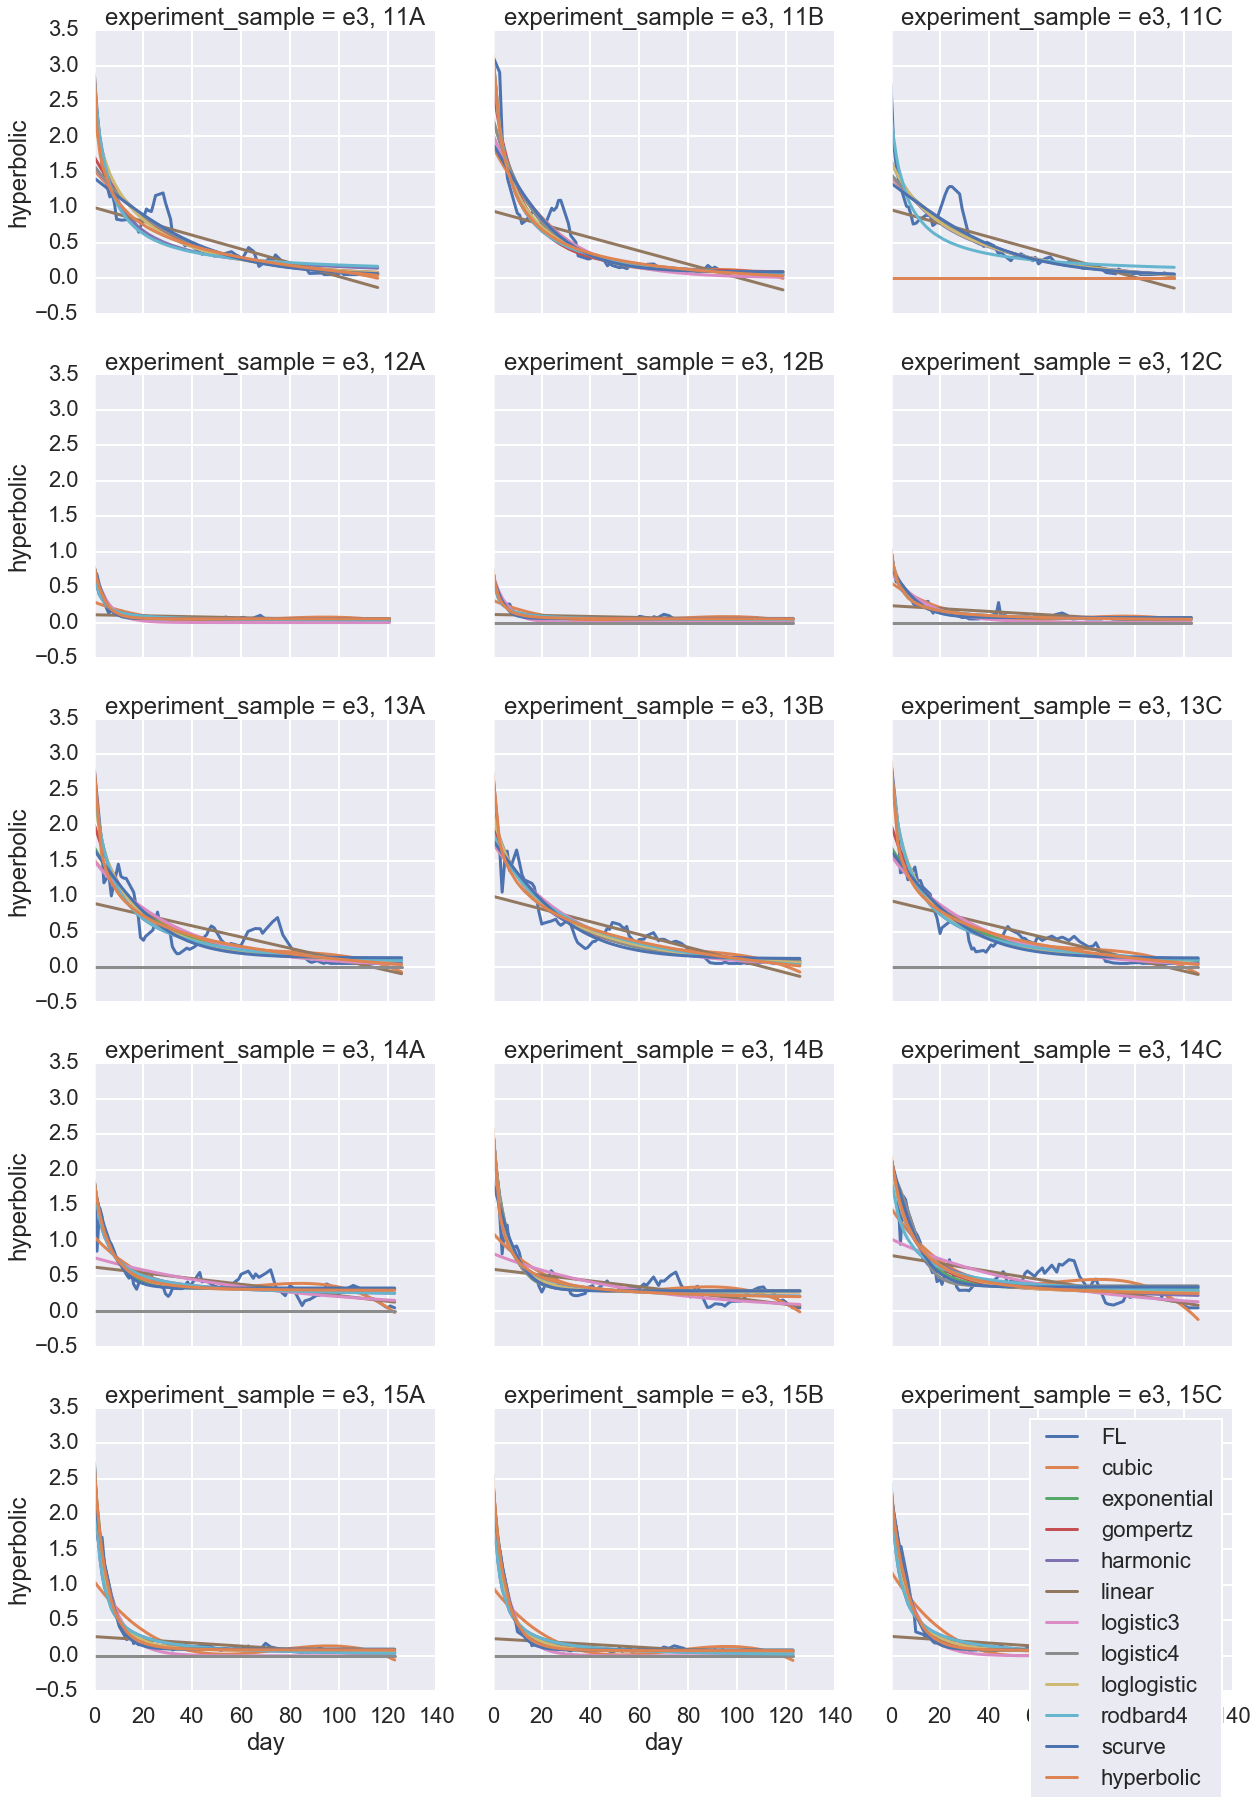

In [19]:
#for e in ['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', ]:
#for e in ['e1' ]:

g = sns.FacetGrid(dfe.loc[(dfe.experiment.isin(['e3'])) & (dfe.culture == 'Co_Culture') & (dfe.ALT == 'DE1')], 
                          col = "experiment_sample", col_wrap=3, height=5, aspect=1.2 , legend_out=True)
cols =     ['FL']
cols.extend(method_cols)
colors = sns.color_palette(n_colors=len(cols), )

for i,p in zip(cols, colors):
    g.map(sns.lineplot, "day", i,  label=i, color=p)
        
plt.legend(loc='best')

In [20]:
def compute_score (df, y_col= 'FL', 
                   ref_cols = method_cols,
                   meta_cols = ('PRO', 'ALT', 'sample', 'culture', 'experiment')
                  ):
    res =  {i :  r2_score(df[y_col], df[i]) for i in ref_cols}
    
    #res.update({f'{i}_log_error' :  mean_squared_log_error(df[y_col], df[i]) for i in ref_cols})
    res.update({i : df[i].unique()[0] for i in meta_cols})
    
    return pd.Series(res)
                   

scores = dfe.groupby('experiment_sample').apply(compute_score)

for i in method_cols:
    scores.loc[scores[i] < 0,i ] = np.nan
scores


,cubic,exponential,gompertz,harmonic,linear,logistic3,logistic4,loglogistic,rodbard4,scurve,hyperbolic,PRO,ALT,sample,culture,experiment
experiment_sample,,,,,,,,,,,,,,,,
"e1, 10A",0.423485,0.930438,0.928540,0.935724,0.149075,0.235701,NaN,0.919511,0.935724,0.921930,0.935919,C9B,DE,10A,Co_Culture,e1
"e1, 10B",0.390028,0.920546,0.924637,0.937349,0.191272,0.277310,NaN,0.911715,0.937349,0.921804,0.937923,C9B,DE,10B,Co_Culture,e1
"e1, 10C",0.333133,0.945157,0.946540,0.947207,0.151826,0.208935,NaN,0.907518,0.947206,0.942340,0.951104,C9B,DE,10C,Co_Culture,e1
"e1, 11A",0.710588,0.955676,0.202028,0.972754,0.236990,0.909763,NaN,0.202028,0.972754,0.933925,0.975108,MED4,DE1,11A,Co_Culture,e1
"e1, 11B",0.652453,0.939501,0.964118,0.978546,0.232238,0.723024,NaN,0.920654,0.978546,0.930056,0.978634,MED4,DE1,11B,Co_Culture,e1
"e1, 11C",0.687152,0.902080,NaN,0.963674,0.319419,0.710399,NaN,0.927832,0.963674,0.890396,0.965965,MED4,DE1,11C,Co_Culture,e1
"e1, 12A",0.593085,0.928814,0.936954,0.933649,0.306816,0.809853,NaN,0.928140,0.933649,0.926567,0.936736,MIT9313,DE1,12A,Co_Culture,e1
"e1, 12B",0.508744,0.900916,0.899752,0.883335,0.240346,0.781134,0.929602,0.886741,0.883335,0.911429,0.896515,MIT9313,DE1,12B,Co_Culture,e1
"e1, 12C",0.527534,0.861010,0.352248,0.837533,0.296398,0.757412,0.907579,0.352248,0.837534,0.877000,0.849926,MIT9313,DE1,12C,Co_Culture,e1


In [21]:
scoresm = scores.melt(id_vars=['PRO','ALT', 'sample', 'culture', 'experiment'],
           value_vars=method_cols, 
                      var_name='method', value_name='r2score'
                     )

In [22]:
scoresm

,PRO,ALT,sample,culture,experiment,method,r2score
0,C9B,DE,10A,Co_Culture,e1,cubic,0.423485
1,C9B,DE,10B,Co_Culture,e1,cubic,0.390028
2,C9B,DE,10C,Co_Culture,e1,cubic,0.333133
3,MED4,DE1,11A,Co_Culture,e1,cubic,0.710588
4,MED4,DE1,11B,Co_Culture,e1,cubic,0.652453
5,MED4,DE1,11C,Co_Culture,e1,cubic,0.687152
6,MIT9313,DE1,12A,Co_Culture,e1,cubic,0.593085
7,MIT9313,DE1,12B,Co_Culture,e1,cubic,0.508744
8,MIT9313,DE1,12C,Co_Culture,e1,cubic,0.527534
9,MIT9312,DE1,13A,Co_Culture,e1,cubic,0.930016


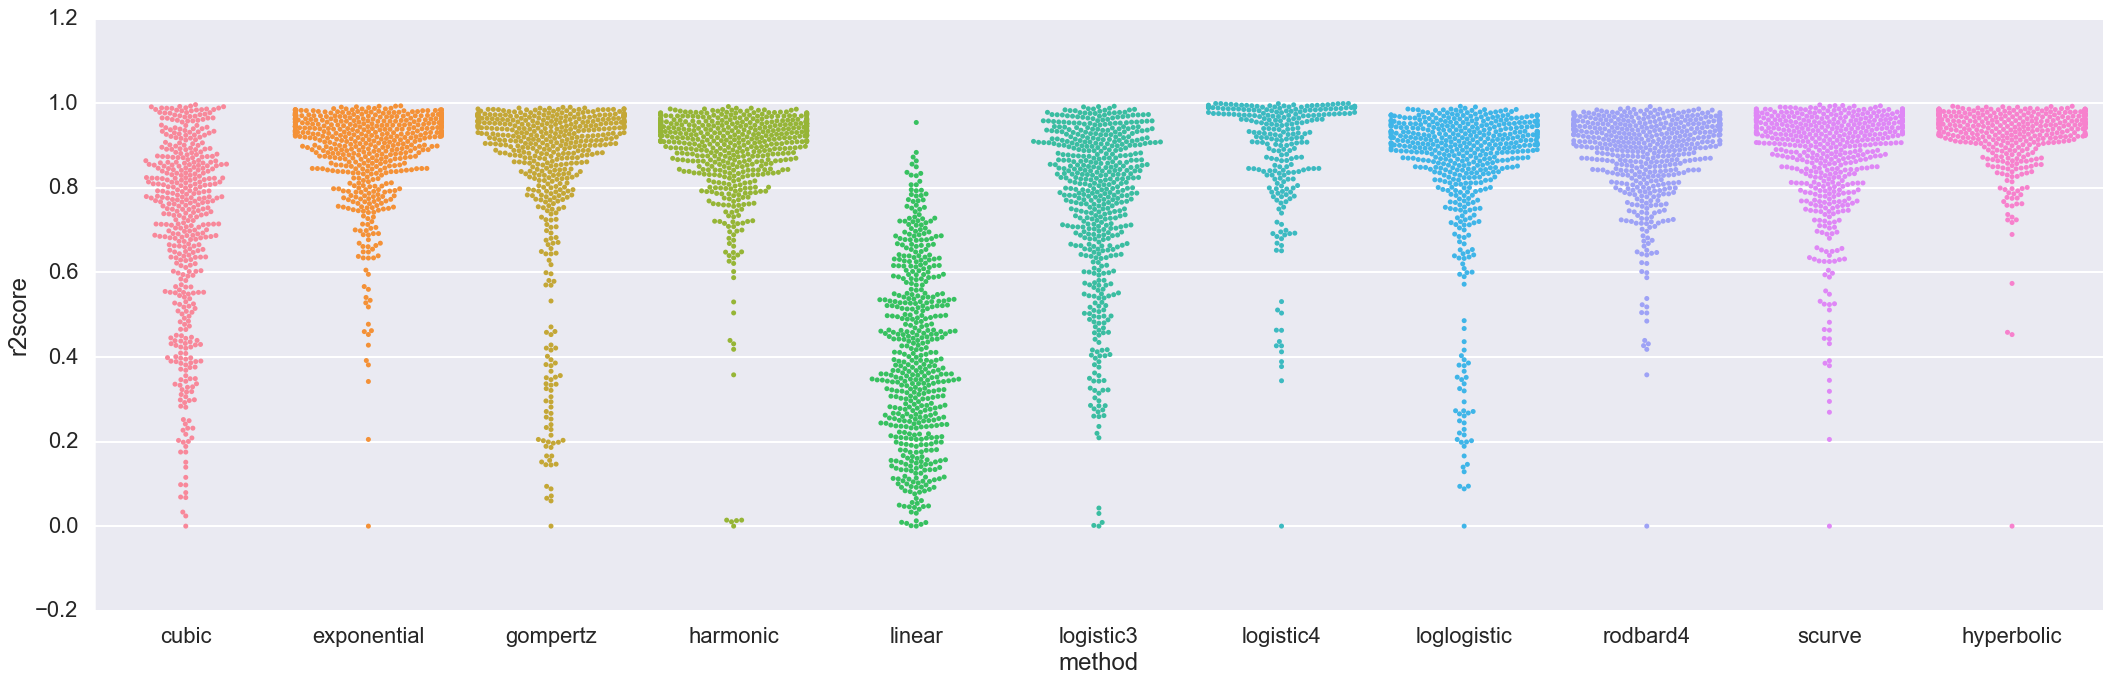

In [23]:
sns.catplot(data=scoresm, x='method', y='r2score', kind='swarm',
            #hue='PRO',
            aspect=3, height=10)

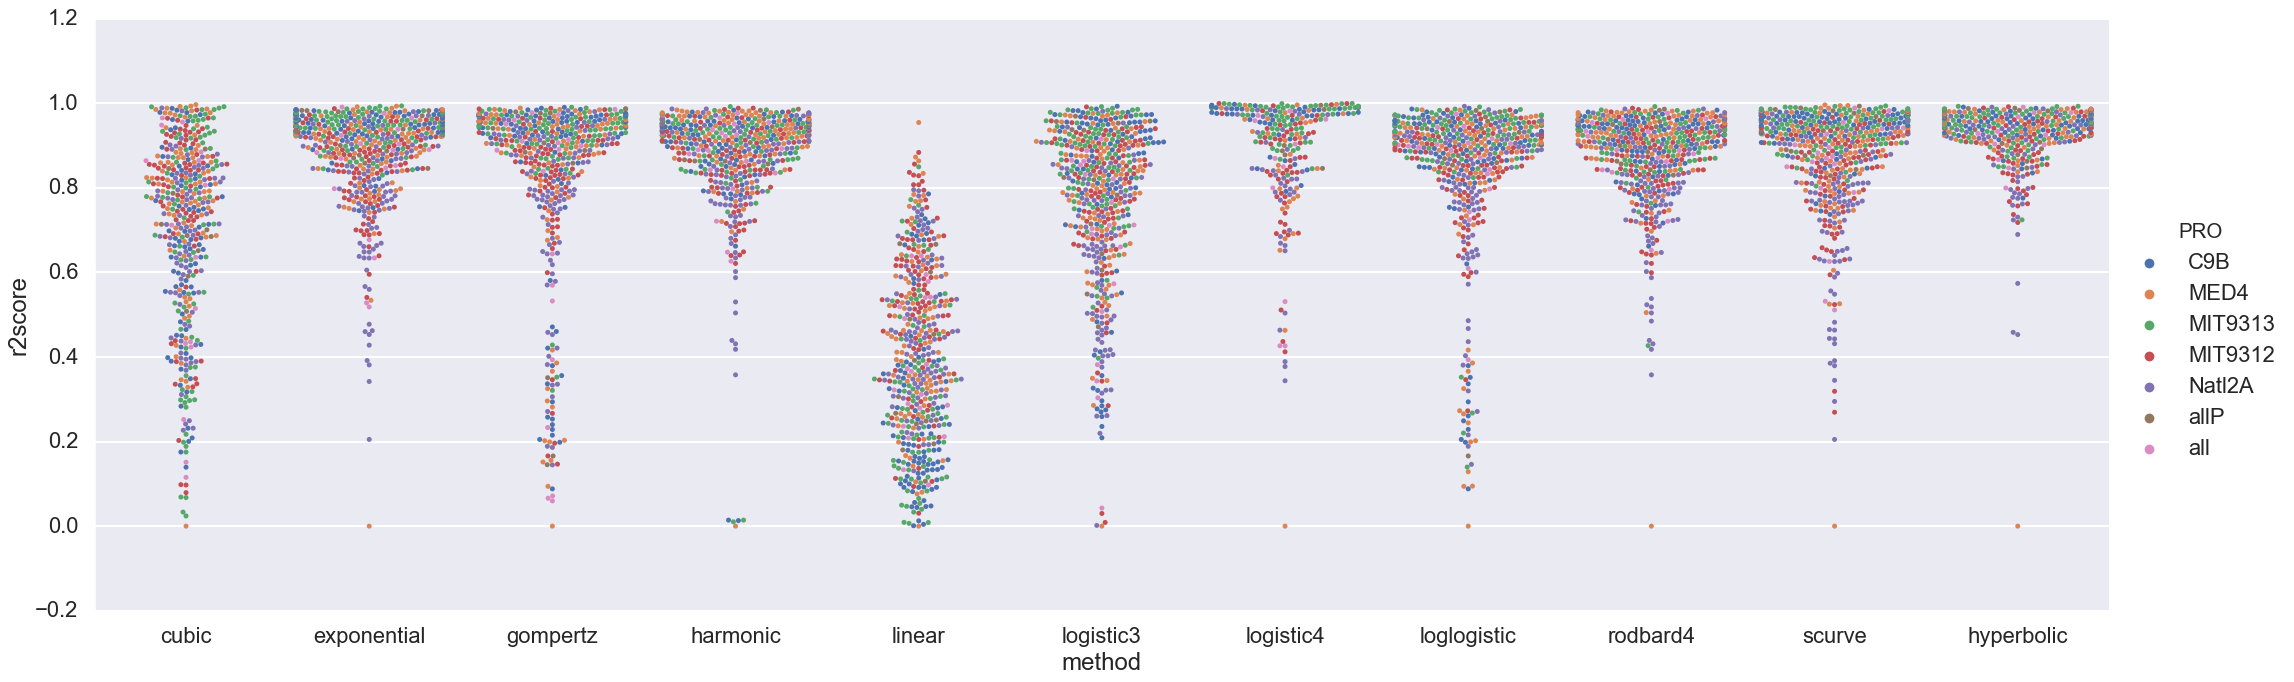

In [24]:
sns.catplot(data=scoresm, x='method', y='r2score', 
            hue='PRO', kind='swarm',
            aspect=3, height=10)

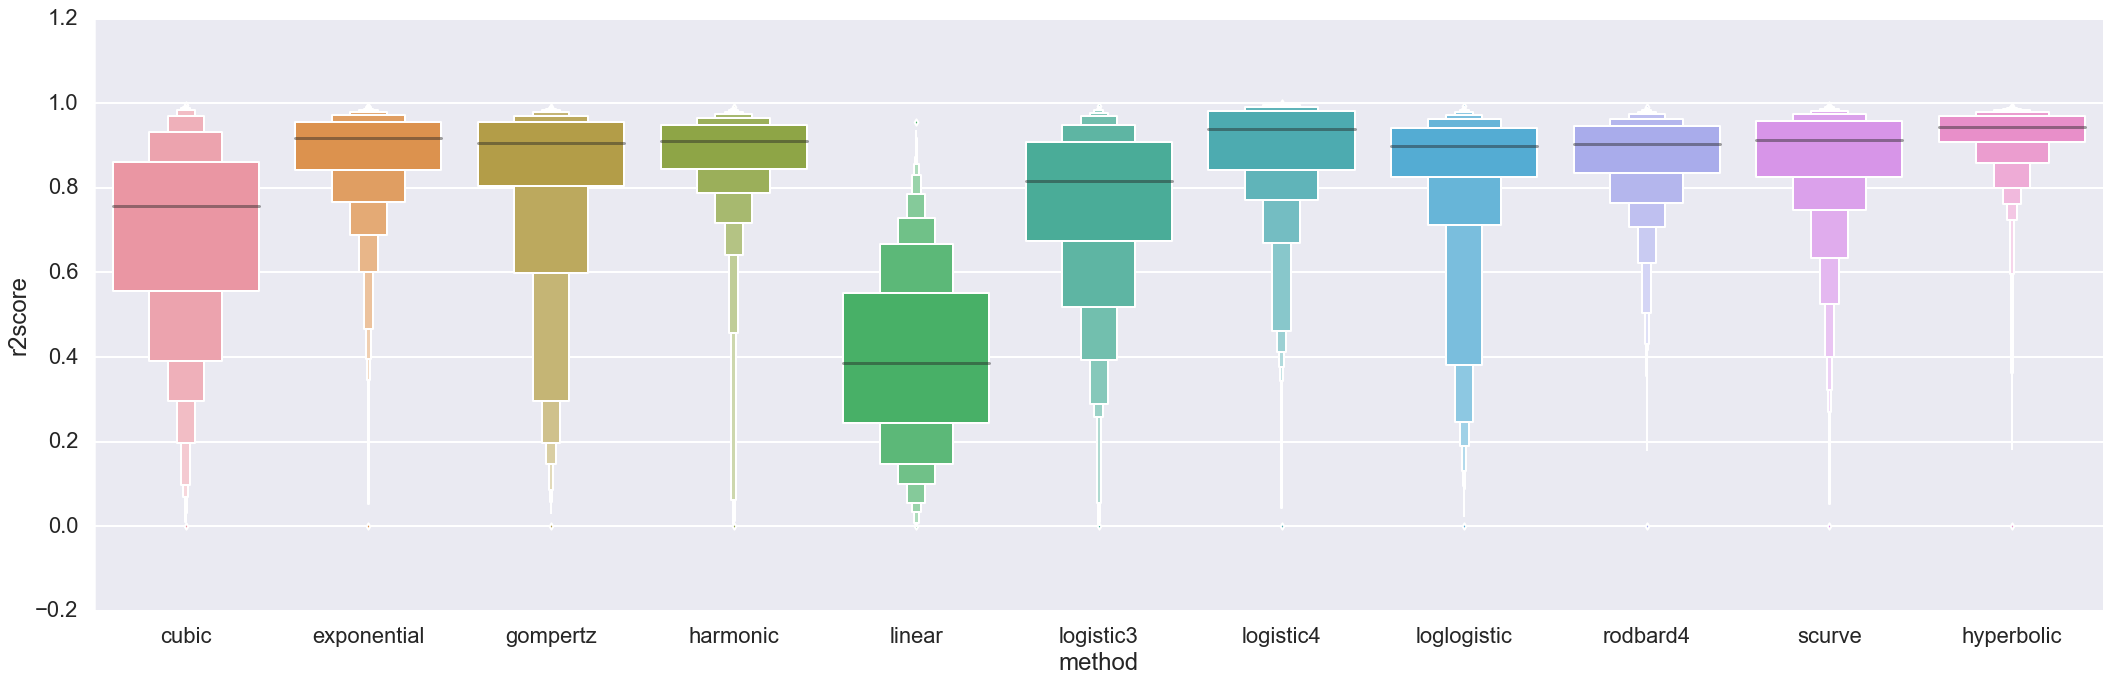

In [25]:
sns.catplot(data=scoresm, x='method', y='r2score', 
            #hue='PRO',
            kind='boxen',
            aspect=3, height=10)

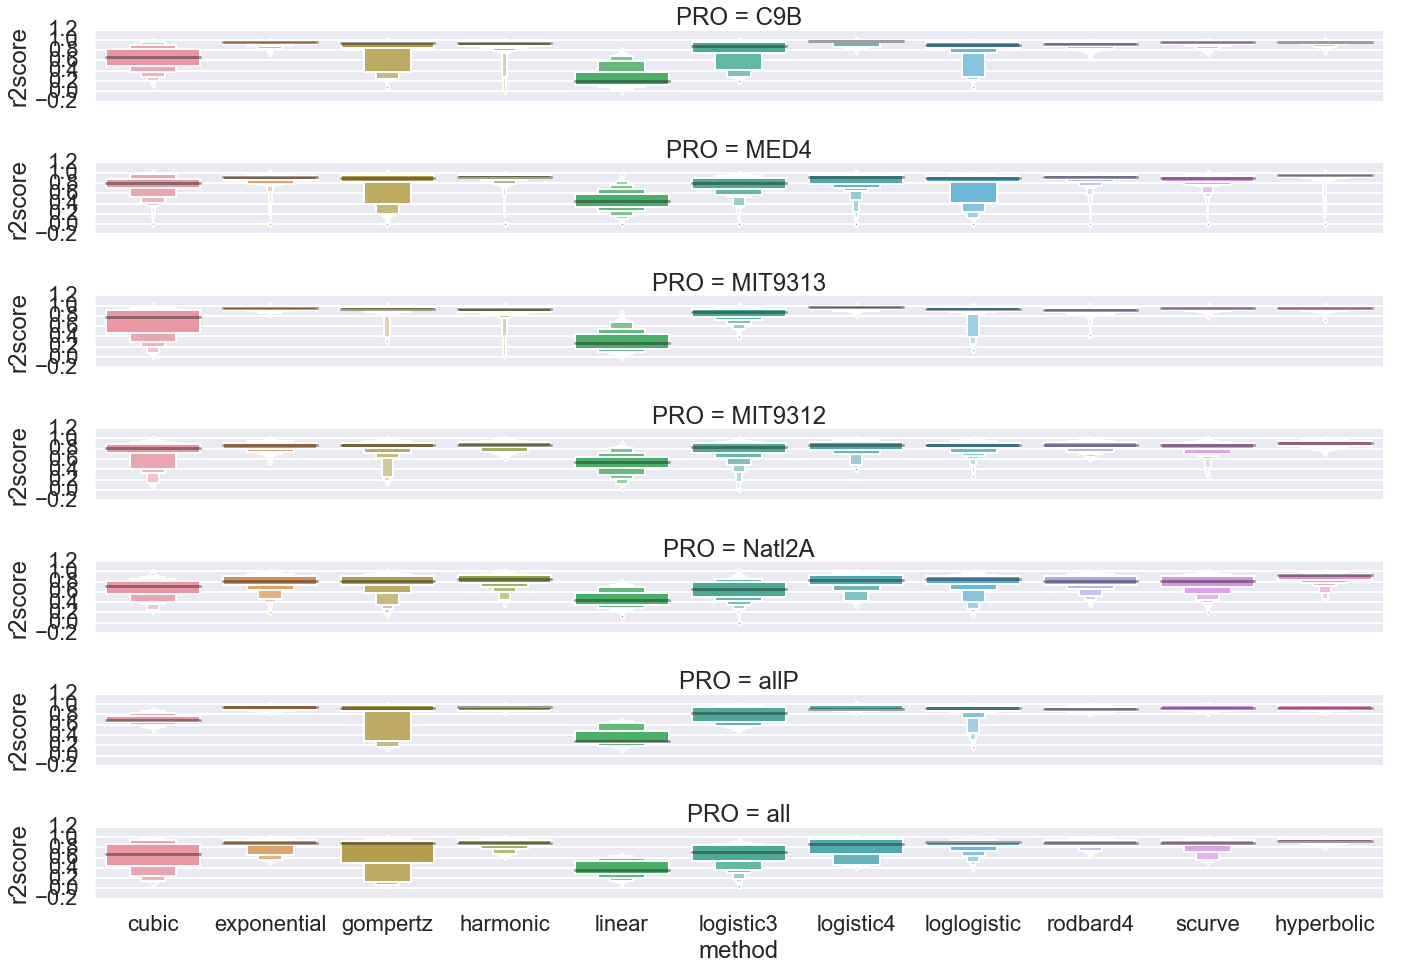

In [51]:
sns.catplot(data=scoresm, x='method', y='r2score', 
            #hue='PRO',
            kind='boxen', 
            row='PRO',
            aspect=10, height=2)

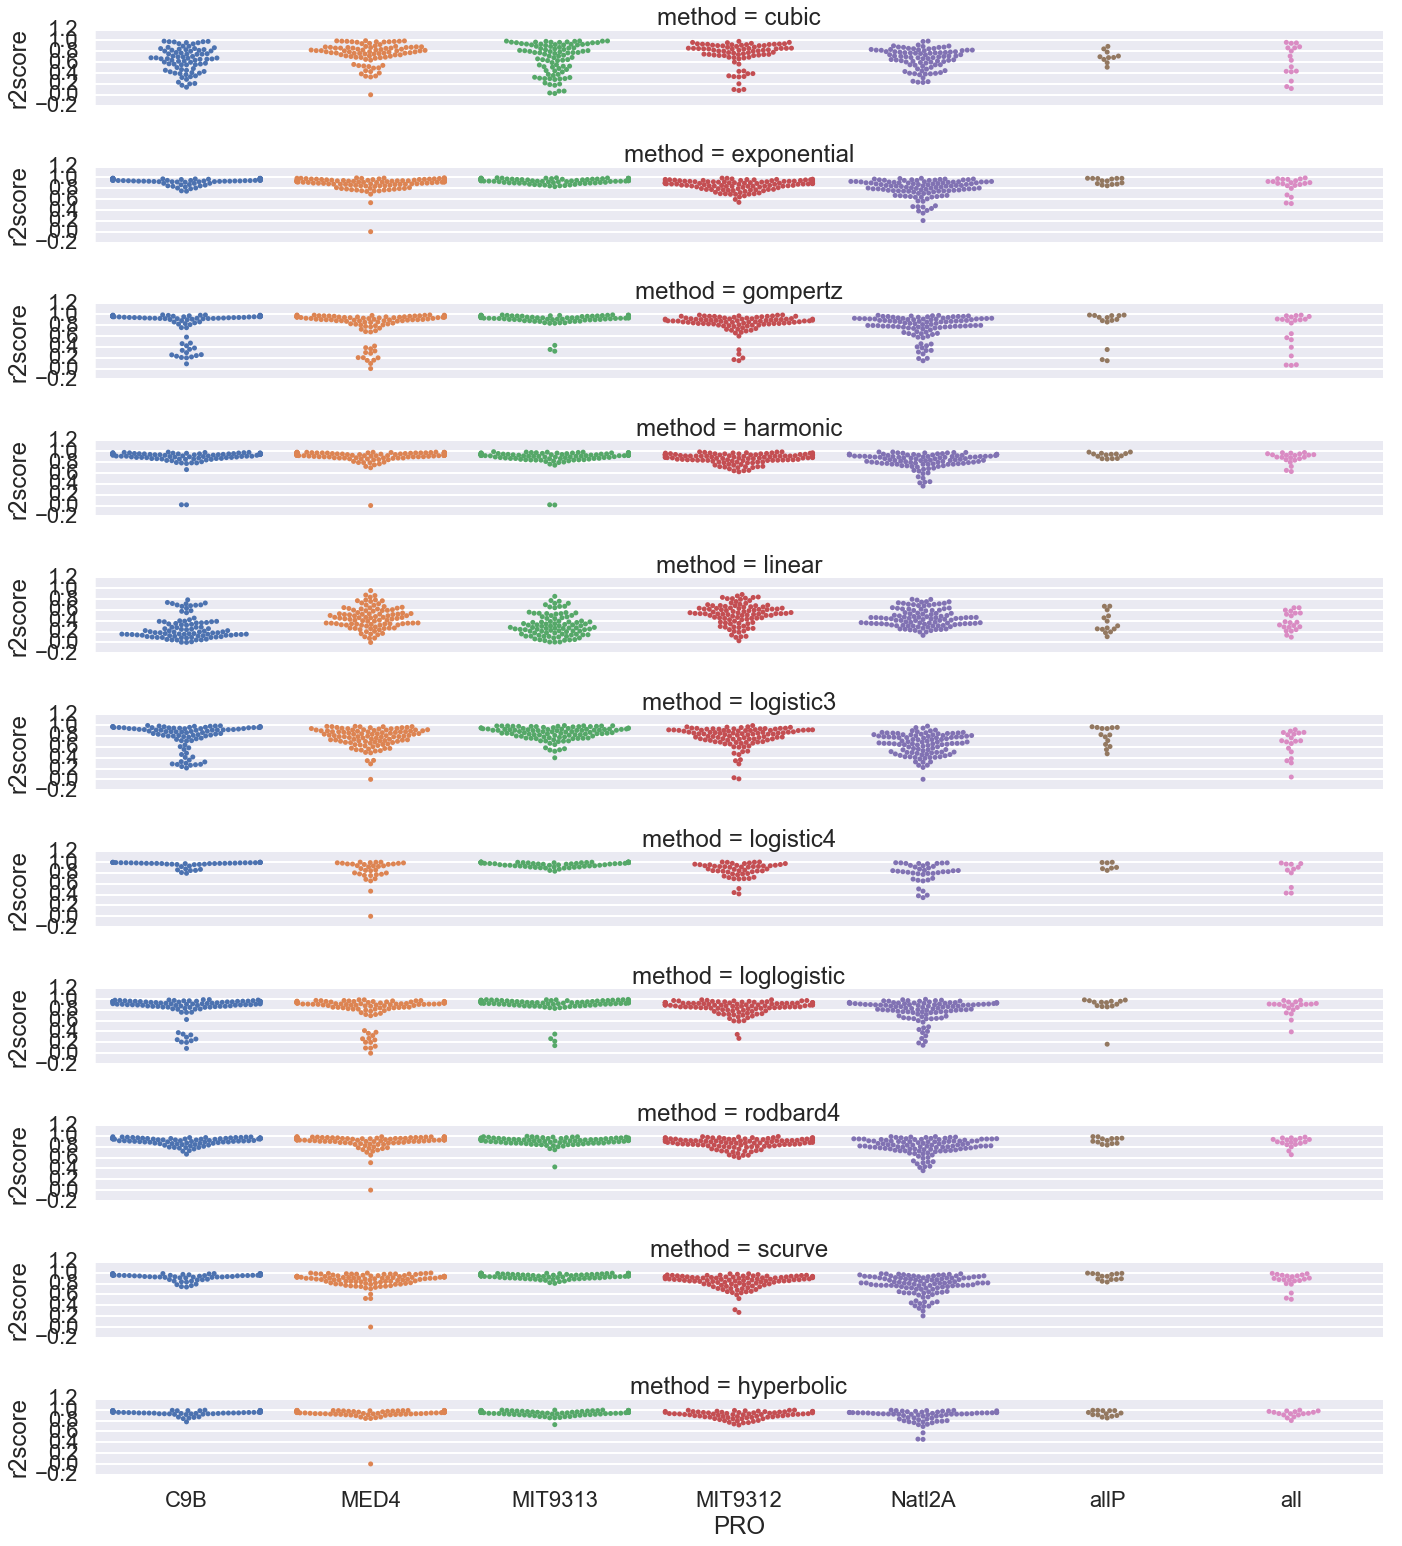

In [52]:
sns.catplot(data=scoresm, x='PRO', y='r2score', 
            #hue='PRO',
            kind='swarm', 
            row='method',
            aspect=10, height=2)

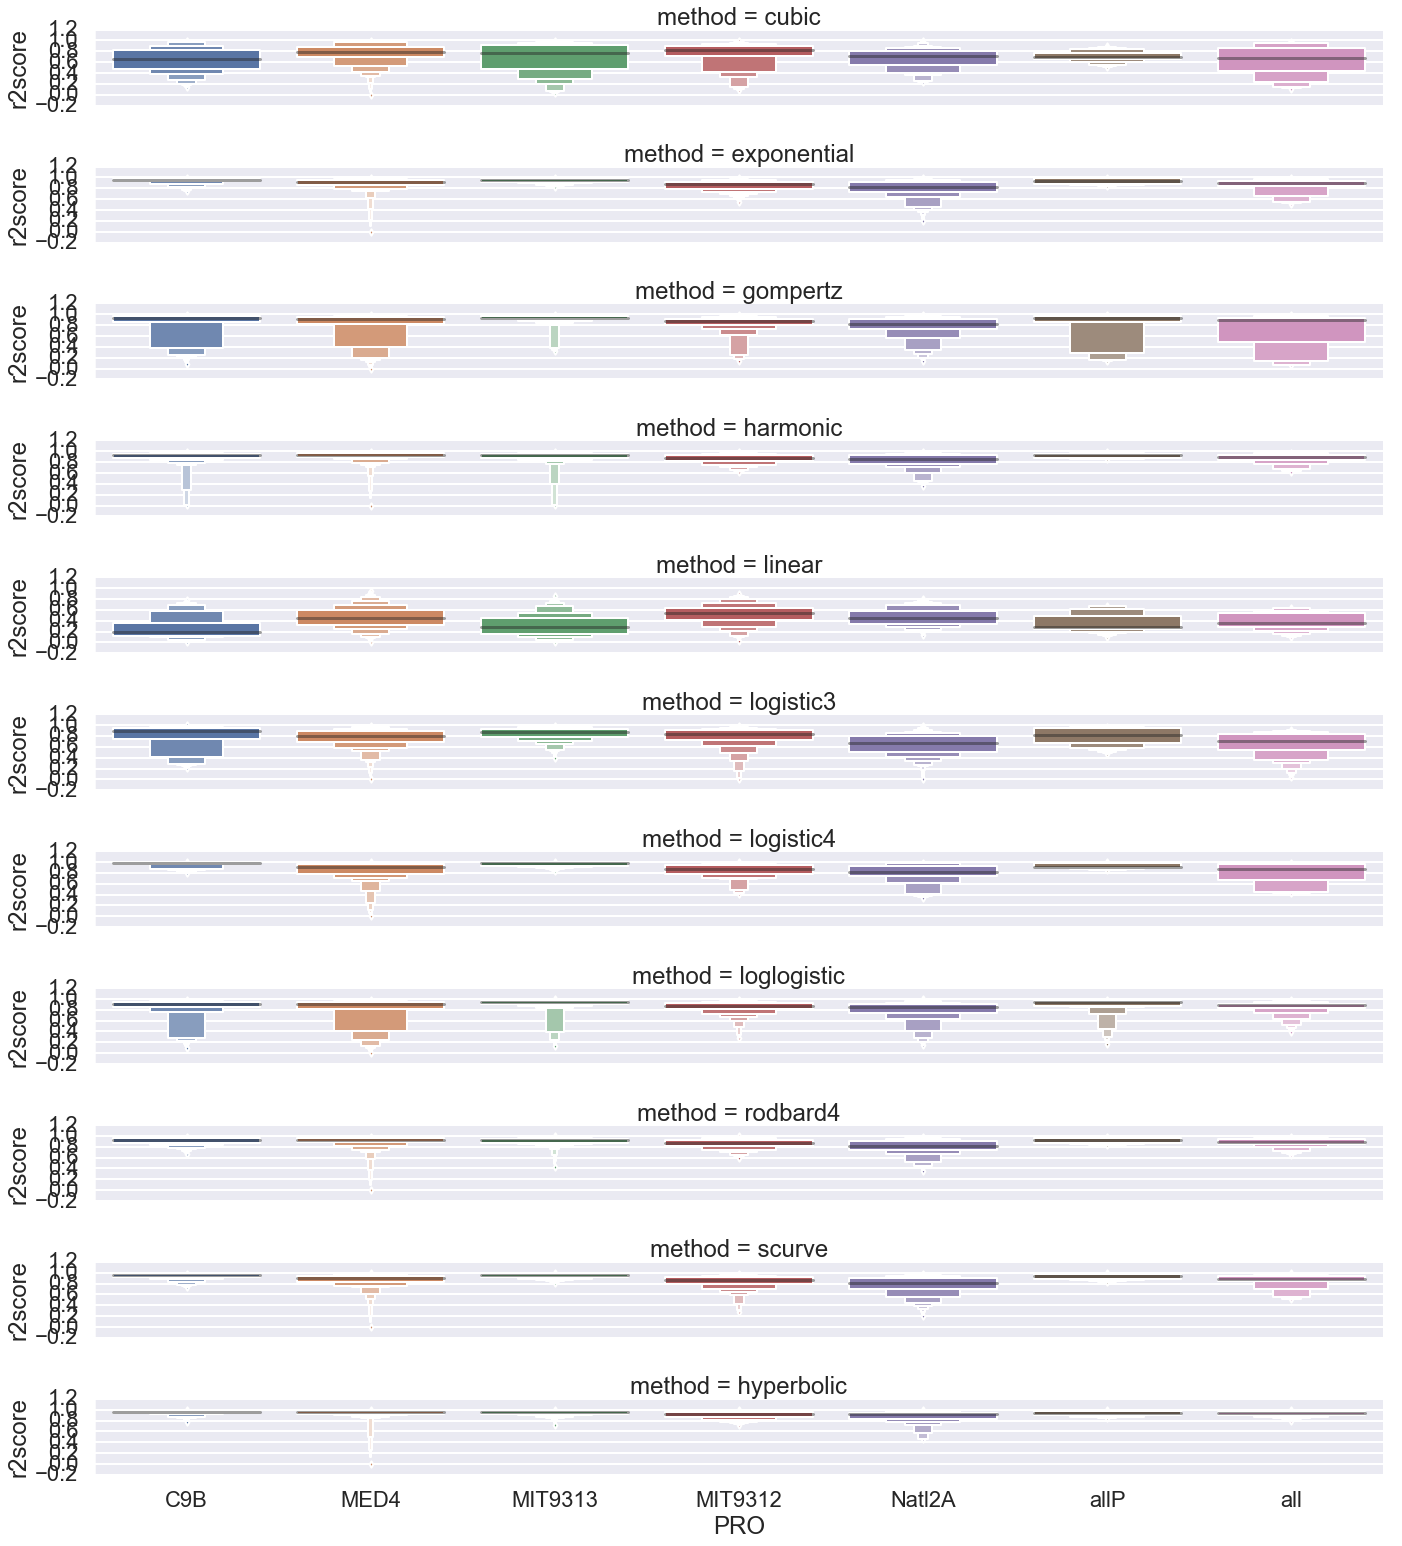

In [53]:
sns.catplot(data=scoresm, x='PRO', y='r2score', 
            #hue='PRO',
            kind='boxen', 
            row='method',
            aspect=10, height=2)

In [29]:
scores.max()

cubic            0.996624
exponential      0.993721
gompertz         0.990522
harmonic         0.992124
linear           0.954468
logistic3         0.99282
logistic4         0.99941
loglogistic      0.992668
rodbard4         0.992124
scurve           0.996031
hyperbolic       0.992794
PRO                  allP
ALT               all_Pro
sample                 9C
culture        Co_Culture
experiment             e7
dtype: object

In [30]:
scores.min()

cubic                0
exponential          0
gompertz             0
harmonic             0
linear               0
logistic3            0
logistic4            0
loglogistic          0
rodbard4             0
scurve               0
hyperbolic           0
PRO                C9B
ALT                1A3
sample             10A
culture        All_Pro
experiment          e1
dtype: object

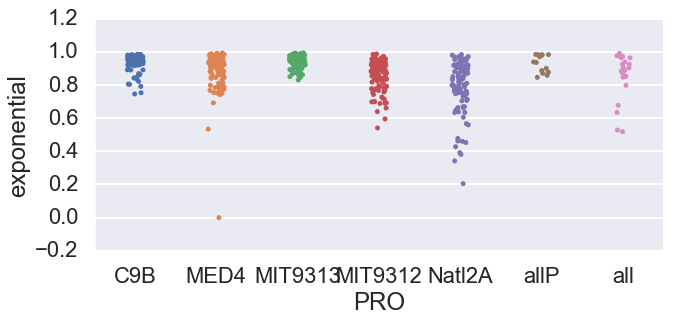

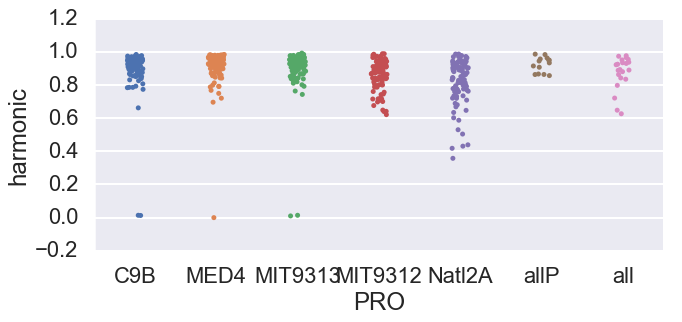

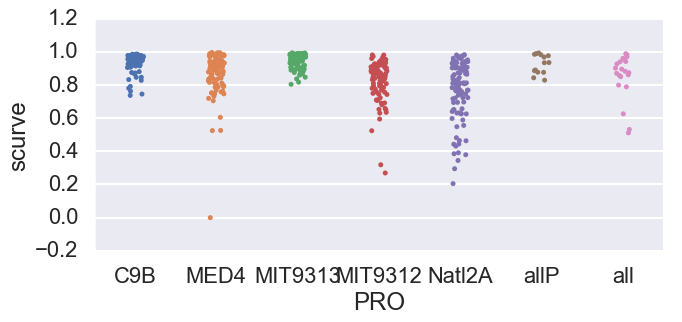

In [31]:
sns.catplot(data=scores, x='PRO', y='exponential', aspect=2)
sns.catplot(data=scores, x='PRO', y='harmonic', aspect=2)
sns.catplot(data=scores, x='PRO', y='scurve', aspect=2)

In [34]:
arr = np.argsort(-scores.loc[:,method_cols].values, axis=1)
best_model = pd.DataFrame(scores.columns[arr], index=scores.index)
for i in ['PRO','ALT', 'sample', 'culture', 'experiment']:
    best_model[i] = scores[i]
best_model

,0,1,2,3,4,5,6,7,8,9,10,PRO,ALT,sample,culture,experiment
experiment_sample,,,,,,,,,,,,,,,,
"e1, 10A",hyperbolic,rodbard4,harmonic,exponential,gompertz,scurve,loglogistic,cubic,logistic3,linear,logistic4,C9B,DE,10A,Co_Culture,e1
"e1, 10B",hyperbolic,harmonic,rodbard4,gompertz,scurve,exponential,loglogistic,cubic,logistic3,linear,logistic4,C9B,DE,10B,Co_Culture,e1
"e1, 10C",hyperbolic,harmonic,rodbard4,gompertz,exponential,scurve,loglogistic,cubic,logistic3,linear,logistic4,C9B,DE,10C,Co_Culture,e1
"e1, 11A",hyperbolic,rodbard4,harmonic,exponential,scurve,logistic3,cubic,linear,gompertz,loglogistic,logistic4,MED4,DE1,11A,Co_Culture,e1
"e1, 11B",hyperbolic,rodbard4,harmonic,gompertz,exponential,scurve,loglogistic,logistic3,cubic,linear,logistic4,MED4,DE1,11B,Co_Culture,e1
"e1, 11C",hyperbolic,rodbard4,harmonic,loglogistic,exponential,scurve,logistic3,cubic,linear,gompertz,logistic4,MED4,DE1,11C,Co_Culture,e1
"e1, 12A",gompertz,hyperbolic,rodbard4,harmonic,exponential,loglogistic,scurve,logistic3,cubic,linear,logistic4,MIT9313,DE1,12A,Co_Culture,e1
"e1, 12B",logistic4,scurve,exponential,gompertz,hyperbolic,loglogistic,harmonic,rodbard4,logistic3,cubic,linear,MIT9313,DE1,12B,Co_Culture,e1
"e1, 12C",logistic4,scurve,exponential,hyperbolic,rodbard4,harmonic,logistic3,cubic,gompertz,loglogistic,linear,MIT9313,DE1,12C,Co_Culture,e1


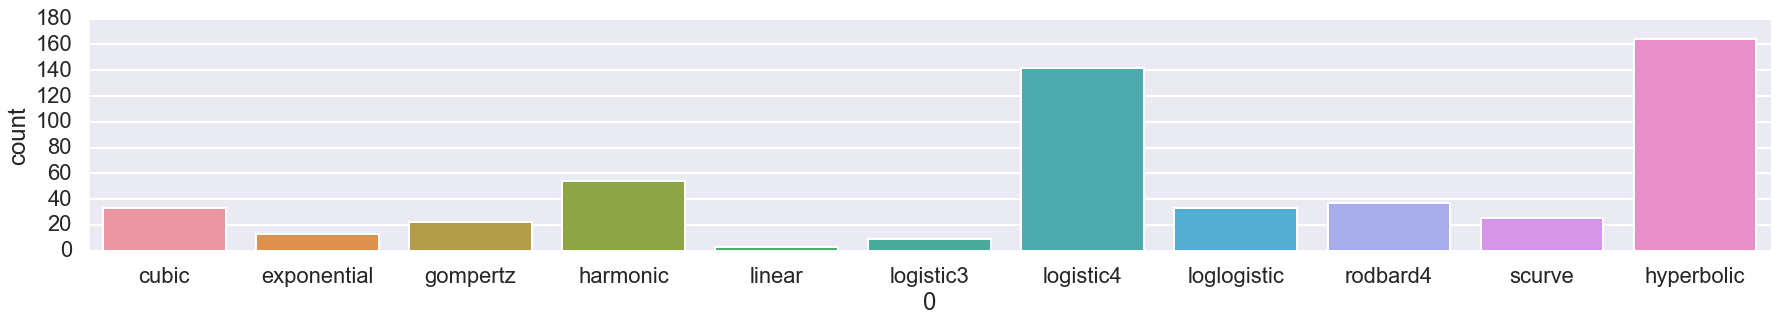

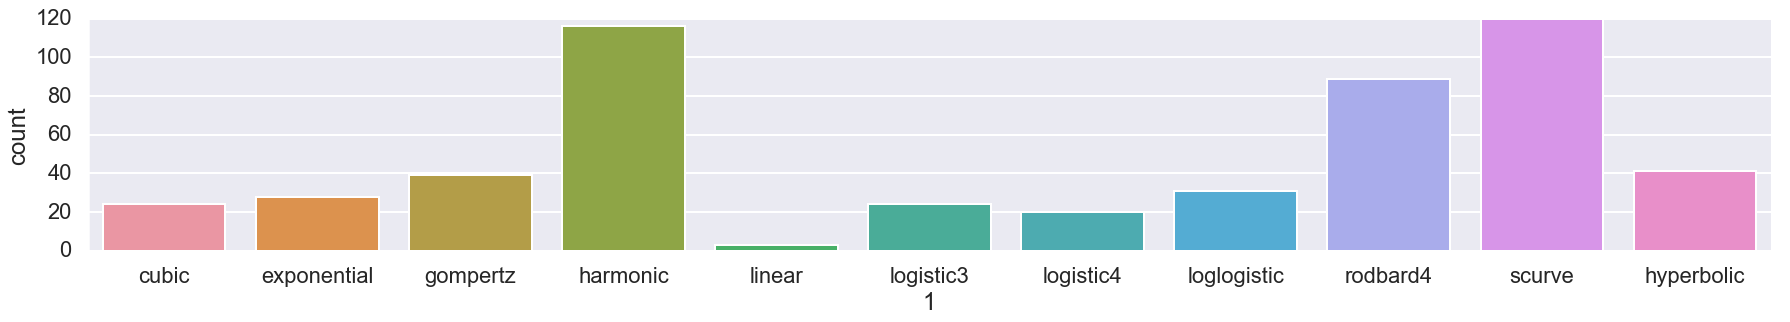

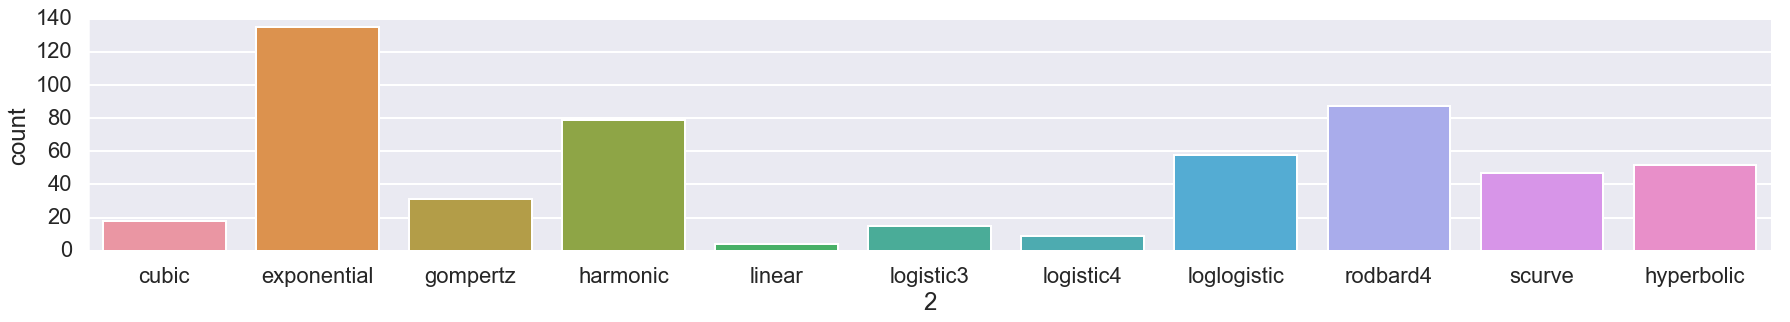

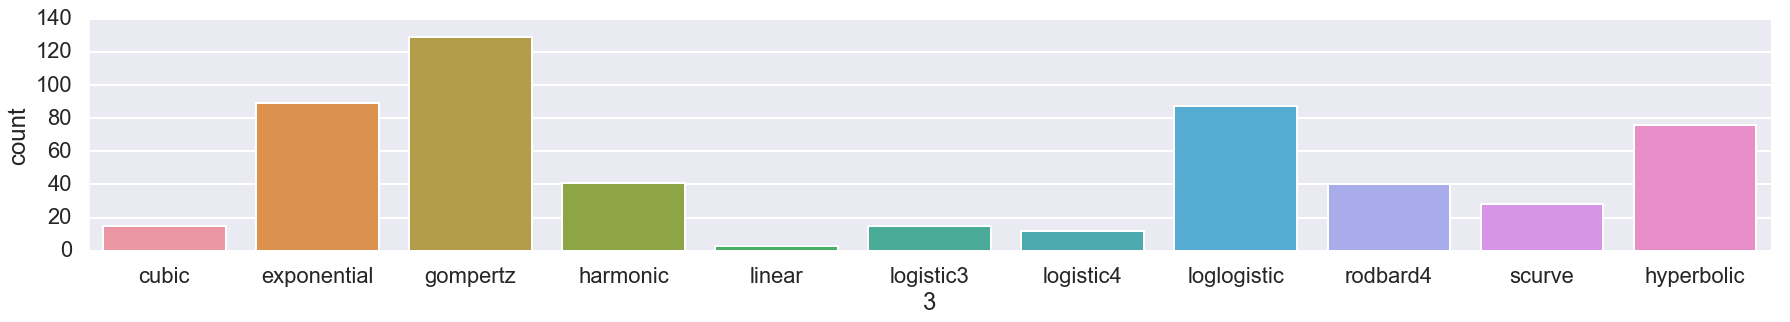

In [48]:


sns.catplot(data=best_model, #x='PRO',
            x=0, kind='count', aspect=5, 
            order=method_cols,
            #row='PRO', 
            #height=2
           )
sns.catplot(data=best_model, #x='PRO',
            x=1, kind='count', aspect=5, #row='PRO', 
            order=method_cols, #height=2
           )
sns.catplot(data=best_model, #x='PRO',
            x=2, kind='count', aspect=5, #row='PRO', 
            order=method_cols,
            #height=2
           )
sns.catplot(data=best_model, #x='PRO',
            x=3, kind='count', aspect=5, #row='PRO', 
            order=method_cols,
            #height=2
           )

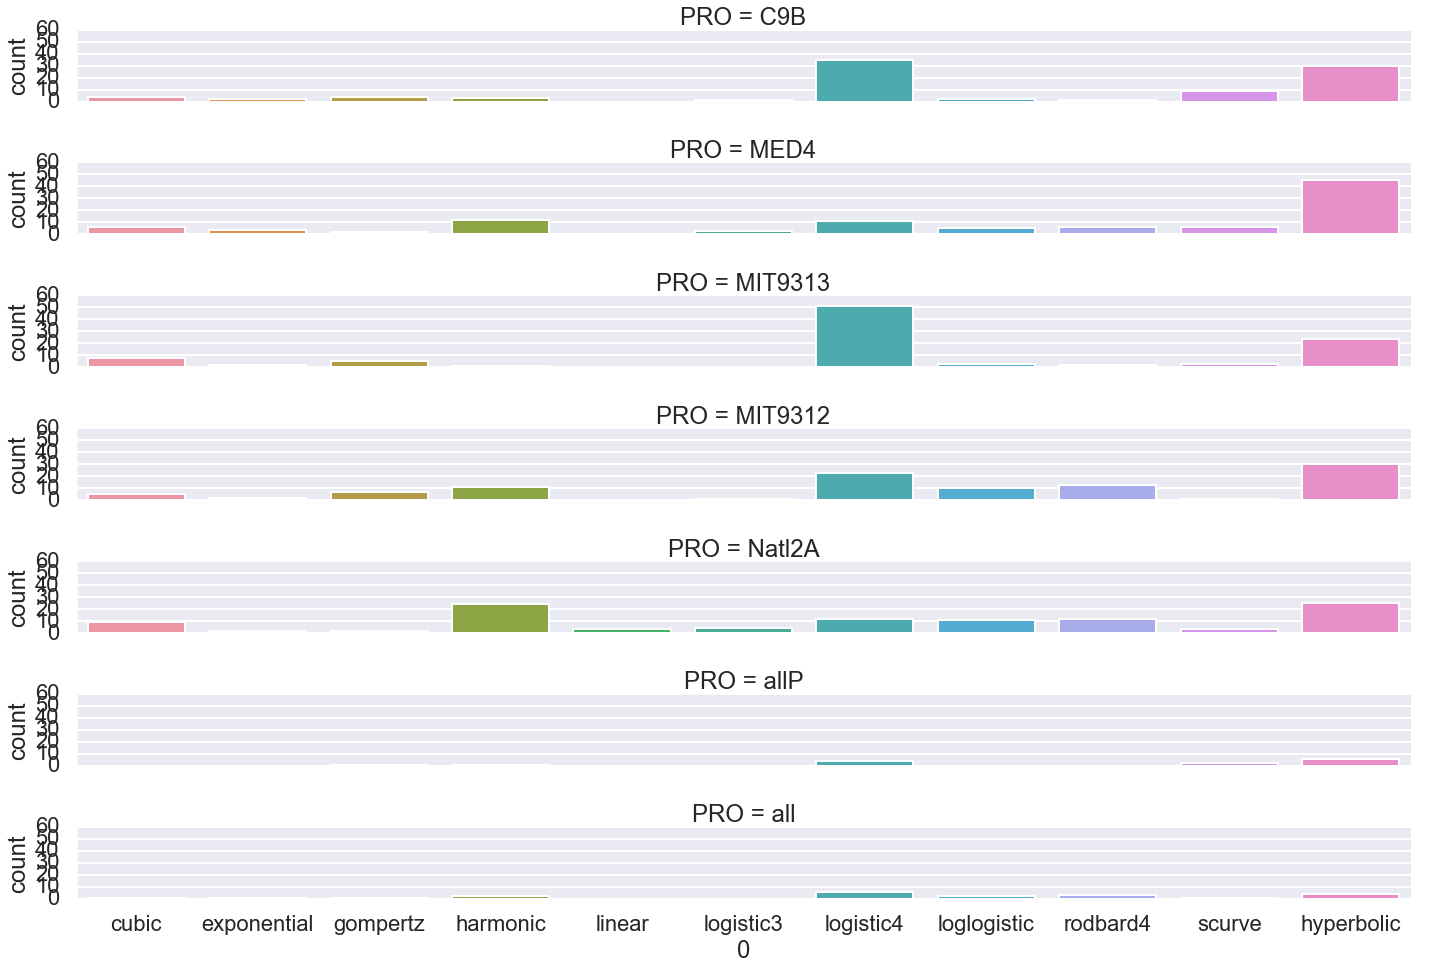

In [49]:
sns.catplot(data=best_model, #x='PRO',
            order=method_cols,
            x=0, kind='count', aspect=10, row='PRO', height=2)

In [40]:
scores.to_pickle('scores.pkl.gz')

In [41]:
dfe.to_pickle('dfe.pkl.gz')